In [1]:

import sys
sys.path.append("../")
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from collections import Counter
import transforms as ext_transforms
from models.enet import ENet
from metric.iou import IoU
from args import get_arguments
from data.utils import enet_weighing, median_freq_balancing
import utils
import glob
import cv2
import transforms as ext_transforms
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
import random

In [2]:
device_enet = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
model_Enet = ENet(12).to(device_enet) #19 for Cityscapes 11 for Camvid

In [4]:
optimizer = optim.Adam(model_Enet.parameters())

In [5]:
model_Enet = utils.load_checkpoint(model_Enet, optimizer, '../save/ENet_CamVid/','ENet' )[0]

In [6]:
street_images = glob.glob("/10TBdrive/sagarj/Soundscapes_vids/samples/*.jpg")

In [7]:
len(street_images)

2691

In [8]:
# image_transform = transforms.Compose( [transforms.Resize((480, 640)), transforms.ToTensor()])
image_transform = transforms.Compose([ToPILImage(),ToTensor()])


In [9]:
model_Enet.eval()

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_c

In [58]:
cityscapes_color_encoding = OrderedDict([
        ('unlabeled', (0, 0, 0)),
        ('road', (128, 64, 128)),
        ('sidewalk', (244, 35, 232)),
        ('building', (70, 70, 70)),
        ('wall', (102, 102, 156)),
        ('fence', (190, 153, 153)),
        ('pole', (153, 153, 153)),
        ('traffic_light', (250, 170, 30)),
        ('traffic_sign', (220, 220, 0)),
        ('vegetation', (107, 142, 35)),
        ('terrain', (152, 251, 152)),
        ('sky', (70, 130, 180)),
        ('person', (220, 20, 60)),
        ('rider', (255, 0, 0)),
        ('car', (0, 0, 142)),
        ('truck', (0, 0, 70)),
        ('bus', (0, 60, 100)),
        ('train', (0, 80, 100)),
        ('motorcycle', (0, 0, 230)),
        ('bicycle', (119, 11, 32))
])

camvid_color_encoding = OrderedDict([
    ('sky', (128, 128, 128)),
    ('building', (128, 0, 0)),
    ('pole', (192, 192, 128)),
    ('road_marking', (255, 69, 0)),
    ('road', (128, 64, 128)),
    ('pavement', (60, 40, 222)),
    ('tree', (128, 128, 0)),
    ('sign_symbol', (192, 128, 128)),
    ('fence', (64, 64, 128)),
    ('car', (64, 0, 128)),
    ('pedestrian', (64, 64, 0)),
    ('bicyclist', (0, 128, 192)),
    ('unlabeled', (0, 0, 0))
])

LabelList = ['sky','building' ,'pole','road_marking', 'road', 'pavement', 'tree','sign_symbol', 'fence', 'car_enet',  'pedestrian',  'bicyclist', 'unlabeled']

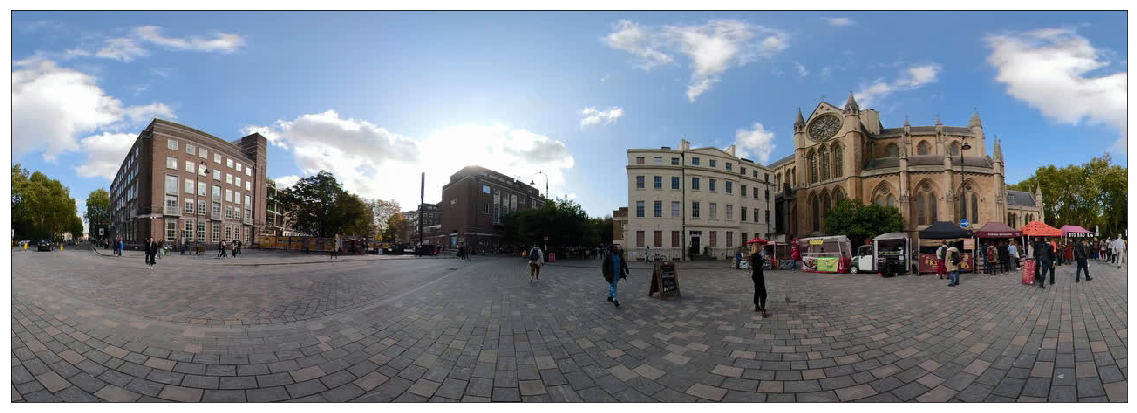

In [59]:

img = cv2.imread(street_images[100])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(height, width , depth) = img.shape
left = 0
top = height // 8
right = width
bottom = 6 * height // 8
img = img[top:bottom,left:right]

plt.figure(figsize=(20,30))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [60]:
img = image_transform(img ).unsqueeze(0).to(device_enet)
pred = model_Enet(img)

In [61]:
# Predictions is one-hot encoded with "num_classes" channels.
# Convert it to a single int using the indices where the maximum (1) occurs
_, predictions = torch.max(pred.data, 1)
pred = predictions.cpu()
label_to_rgb = transforms.Compose([
    ext_transforms.LongTensorToRGBPIL(camvid_color_encoding),
    transforms.ToTensor()
])
color_predictions = utils.batch_transform(predictions.cpu(), label_to_rgb)
# utils.imshow_batch(pred.data.cpu(), color_predictions)

In [62]:
fractionArray = {LabelList[k]:float(np.count_nonzero(pred == k))/(float(pred.shape[1]*pred.shape[2])) for k in range(12)}
print(fractionArray)

{'sky': 0.3086041666666667, 'building': 0.17819097222222222, 'pole': 0.013097222222222222, 'road_marking': 0.301359375, 'road': 0.046940972222222224, 'pavement': 0.09416319444444445, 'tree': 0.004027777777777778, 'sign_symbol': 0.003529513888888889, 'fence': 0.031131944444444445, 'car_enet': 0.011961805555555555, 'pedestrian': 0.006993055555555555, 'bicyclist': 0.0}


In [63]:
color_predictions = utils.batch_transform(predictions.cpu(), label_to_rgb)

In [64]:
# color_predictions

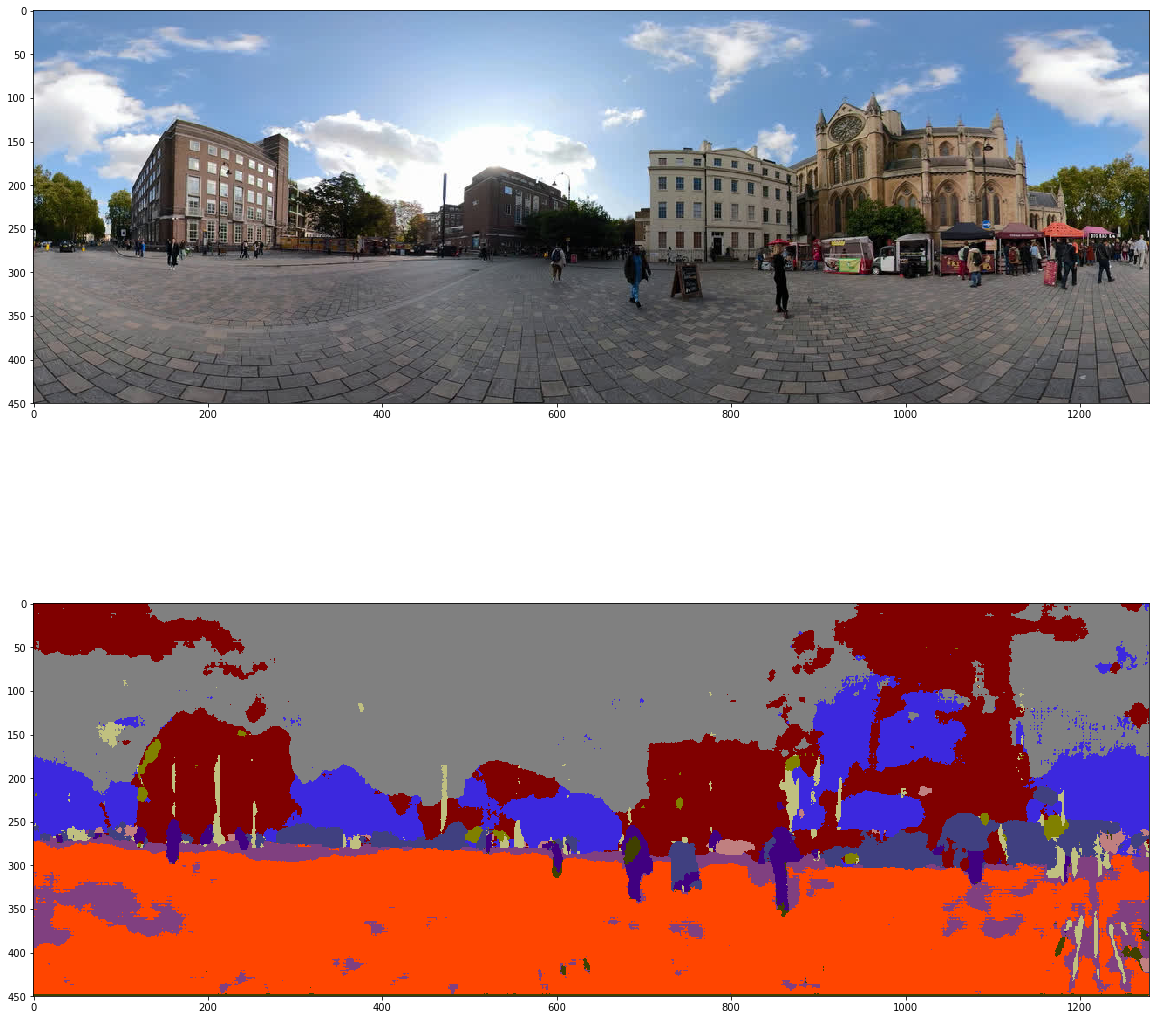

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
images = torchvision.utils.make_grid(img.cpu()).numpy()
labels = torchvision.utils.make_grid(color_predictions).numpy()
ax1.imshow(np.transpose(images, (1, 2, 0)))
ax2.imshow(np.transpose(labels, (1, 2, 0)))

plt.show()


In [66]:
device_objects = torch.device('cuda:6') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(device_objects)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [67]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car_coco', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

transformations = Compose([ToPILImage(),ToTensor()])

def get_prediction(image, threshold):
#     i = cv2.imread(img_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    img = transformations(img).unsqueeze(0).to(device)
    print(img.shape)
    pred = model(img)

    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
    if len(pred_t) > 0:
        pred_t = pred_t[-1]
        masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
        pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
        masks = masks[:pred_t+1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
        return masks, pred_boxes, pred_class
    else:
        return [] , [] , []



def get_frame_prediction(frame, threshold):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
    img = transformations(img).unsqueeze(0).to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class
    

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [68]:
def instance_segmentation_api(img, threshold=0.5, rect_th=3, text_size=0.1, text_th=3):
#     img = cv2.imread(img_path)
    masks, boxes, pred_cls = get_prediction(img, threshold)    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     for i in range(len(masks)):
#         rgb_mask = random_colour_masks(masks[i])
#         img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
#         cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
#         cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
#     plt.figure(figsize=(20,30))
#     plt.imshow(img)
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    return boxes , pred_cls , masks

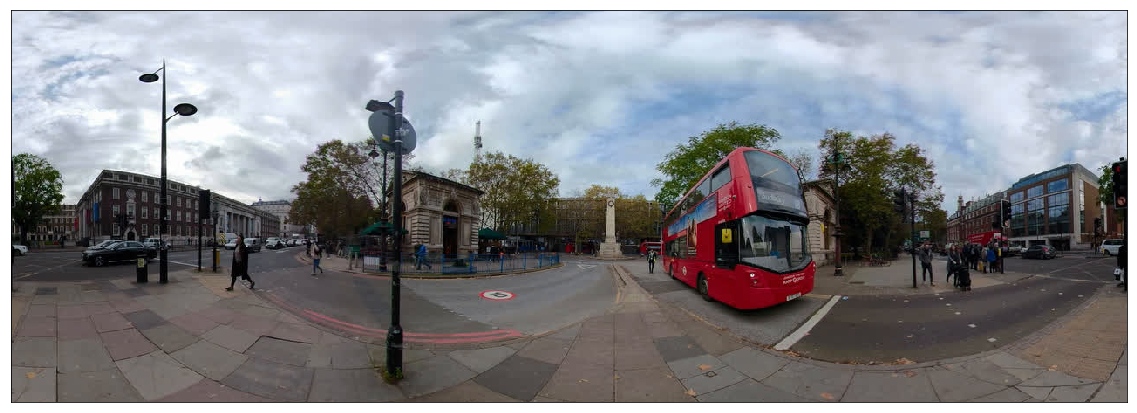

In [69]:
img = cv2.imread(street_images[12])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(height, width , depth) = img.shape
left = 0
top = height // 8
right = width
bottom = 6 * height // 8
crop_img = img[top:bottom,left:right]

plt.figure(figsize=(20,30))
plt.imshow(crop_img)
plt.xticks([])
plt.yticks([])
plt.show()

In [70]:
_ , pred_cls, masks = instance_segmentation_api(crop_img,rect_th=1, text_size=1,text_th=1)

torch.Size([1, 3, 450, 1280])


In [71]:
def classEntropy(predCls):
    counts = Counter(pred_cls)
    classProb = [float(counts[k])/float(len(COCO_INSTANCE_CATEGORY_NAMES)) for k in counts]
#     print(classProb,counts)
    entropy = - sum([classProb[i]*np.log(classProb[i]) for i in range(len(classProb))])
    return counts , entropy

def EnetEntropy(pred):
    fractionArray = {LabelList[k]:float(np.count_nonzero(pred == k))/(float(pred.shape[1]*pred.shape[2])) for k in range(len(LabelList))}
    print(fractionArray)
    entropy = - sum([fractionArray[i]*np.log(fractionArray[i]) for i in fractionArray if fractionArray[i] > 0 ])
    return fractionArray, entropy

def classPercentage(pred_cls,masks):
    classPercentage = {}
    for k in range(len(pred_cls)):
        label = pred_cls[k]
        if label not in classPercentage:
            classPercentage[label] = sum(masks[k].ravel())
        else:
            classPercentage[label] += sum(masks[k].ravel())
    normed_Class_percentage = {k:float(classPercentage[k])/float(masks.shape[1]*masks.shape[2]) for k in classPercentage}
    return normed_Class_percentage

def readImage(imgPath):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (height, width , depth) = img.shape
    left = 0
    top = height // 8
    right = width
    bottom = 6 * height // 8
    img = img[top:bottom,left:right]
    return img

In [72]:
print(classPercentage(pred_cls , masks) , classEntropy(pred_cls))

{'person': 0.009800347222222222, 'car_coco': 0.008225694444444445, 'bus': 0.04384548611111111, 'traffic light': 0.0006753472222222223, 'umbrella': 0.0006597222222222222} (Counter({'person': 17, 'car_coco': 9, 'bus': 1, 'traffic light': 1, 'umbrella': 1}), 0.6909371169671099)


In [73]:
classEntropy(pred_cls)

(Counter({'bus': 1,
          'car_coco': 9,
          'person': 17,
          'traffic light': 1,
          'umbrella': 1}),
 0.6909371169671099)

In [74]:
EnetEntropy(pred)

{'sky': 0.3086041666666667, 'building': 0.17819097222222222, 'pole': 0.013097222222222222, 'road_marking': 0.301359375, 'road': 0.046940972222222224, 'pavement': 0.09416319444444445, 'tree': 0.004027777777777778, 'sign_symbol': 0.003529513888888889, 'fence': 0.031131944444444445, 'car_enet': 0.011961805555555555, 'pedestrian': 0.006993055555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}


({'bicyclist': 0.0,
  'building': 0.17819097222222222,
  'car_enet': 0.011961805555555555,
  'fence': 0.031131944444444445,
  'pavement': 0.09416319444444445,
  'pedestrian': 0.006993055555555555,
  'pole': 0.013097222222222222,
  'road': 0.046940972222222224,
  'road_marking': 0.301359375,
  'sign_symbol': 0.003529513888888889,
  'sky': 0.3086041666666667,
  'tree': 0.004027777777777778,
  'unlabeled': 0.0},
 1.6923039739953283)

In [75]:
street_images[0]

'/10TBdrive/sagarj/Soundscapes_vids/samples/CamdenMarket1_EQR_720p_15300.jpg'

In [76]:
FieldNames = ['VidName','FrameNumber','ObjEntropy','SceneEntropy'] + COCO_INSTANCE_CATEGORY_NAMES + LabelList
df_Dict = {k : [] for k in FieldNames} 

In [83]:
def updateEnet(enetDict , df_dict):
    for k in LabelList:
        if k in enetDict:
            df_dict[k].append(enetDict[k])
        else:
            df_dict[k].append(0.0)

def updateObjects(objDict , df_dict):
    for k in COCO_INSTANCE_CATEGORY_NAMES:
        if k in objDict:
            df_dict[k].append(objDict[k])
        else:
            df_dict[k].append(0)

for imgPath in street_images:
    frameSeg = imgPath.split('/')[-1].split('.')[0]
    vid_name = frameSeg.split('_')[:-1]
    FrameNo = frameSeg.split('_')[-1]
    
    df_Dict['FrameNumber'].append(FrameNo)
    df_Dict['VidName'].append('_'.join(vid_name))
    
    print(vid_name,FrameNo)
    _image = readImage(imgPath)
    _ , pred_cls, masks = instance_segmentation_api(_image ,rect_th=1, text_size=1,text_th=1)
    img = image_transform(_image).unsqueeze(0).to(device_enet)
    pred = model_Enet(img)
    _, predictions = torch.max(pred.data, 1)
    pred = predictions.cpu()
    
    objCount , objEntropy = classEntropy(pred_cls)
    enetFrac , enetEntropy = EnetEntropy(pred)
    
    df_Dict['ObjEntropy'].append(objEntropy)
    df_Dict['SceneEntropy'].append(enetEntropy)
    
    updateEnet(enetFrac,df_Dict)
    updateObjects(objCount,df_Dict)
    
    

['CamdenMarket1', 'EQR', '720p'] 15300
torch.Size([1, 3, 450, 1280])
{'sky': 0.40766319444444443, 'building': 0.092421875, 'pole': 0.03276736111111111, 'road_marking': 0.2274253472222222, 'road': 0.03439930555555556, 'pavement': 0.03, 'tree': 0.019706597222222223, 'sign_symbol': 0.00011284722222222222, 'fence': 0.12872916666666667, 'car_enet': 0.020338541666666668, 'pedestrian': 0.006435763888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkFields2', 'EQR', '720p'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.07768229166666667, 'building': 0.13232118055555556, 'pole': 0.004595486111111111, 'road_marking': 0.248265625, 'road': 0.029039930555555555, 'pavement': 0.45824479166666665, 'tree': 0.012020833333333333, 'sign_symbol': 0.010611111111111111, 'fence': 0.02270138888888889, 'car_enet': 5.902777777777778e-05, 'pedestrian': 0.004458333333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 3600
torch.Size([1, 3, 450, 1280])
{'sky': 0.38735416666666667, 'bui

{'sky': 0.2503356481481481, 'building': 0.0416141975308642, 'pole': 0.0018055555555555555, 'road_marking': 0.12058796296296297, 'road': 0.06483256172839506, 'pavement': 0.47613734567901234, 'tree': 0.0028016975308641973, 'sign_symbol': 0.011561728395061728, 'fence': 0.030319444444444444, 'car_enet': 0.0, 'pedestrian': 3.858024691358025e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 600
torch.Size([1, 3, 450, 1280])
{'sky': 0.4119861111111111, 'building': 0.07681944444444444, 'pole': 0.027949652777777778, 'road_marking': 0.18721527777777777, 'road': 0.05940277777777778, 'pavement': 0.023491319444444443, 'tree': 0.016725694444444446, 'sign_symbol': 0.003796875, 'fence': 0.16940972222222223, 'car_enet': 0.013227430555555555, 'pedestrian': 0.009975694444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 33600
torch.Size([1, 3, 450, 1280])
{'sky': 0.24487152777777776, 'building': 0.17310416666666667, 'pole': 0.008458333333333333, 'road_m

torch.Size([1, 3, 450, 1280])
{'sky': 0.3927934027777778, 'building': 0.07230208333333334, 'pole': 0.028506944444444446, 'road_marking': 0.2615763888888889, 'road': 0.08625173611111112, 'pavement': 0.08344444444444445, 'tree': 0.008822916666666666, 'sign_symbol': 0.003984375, 'fence': 0.047390625, 'car_enet': 0.008350694444444445, 'pedestrian': 0.0065763888888888886, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 23400
torch.Size([1, 3, 450, 1280])
{'sky': 0.42516493055555554, 'building': 0.126015625, 'pole': 0.011208333333333334, 'road_marking': 0.17975694444444446, 'road': 0.04645833333333333, 'pavement': 0.0796579861111111, 'tree': 0.016546875, 'sign_symbol': 0.00014409722222222222, 'fence': 0.1065017361111111, 'car_enet': 0.003401041666666667, 'pedestrian': 0.005144097222222223, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 24900
torch.Size([1, 3, 450, 1280])
{'sky': 0.34009375, 'building': 0.18310590277777777, 'pole': 0.017383680555555555, 'roa

{'sky': 0.2511302083333333, 'building': 0.1800277777777778, 'pole': 0.010911458333333334, 'road_marking': 0.1644079861111111, 'road': 0.051375, 'pavement': 0.2827951388888889, 'tree': 0.014751736111111111, 'sign_symbol': 0.005914930555555555, 'fence': 0.02575, 'car_enet': 0.004798611111111111, 'pedestrian': 0.008137152777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 5700
torch.Size([1, 3, 675, 1920])
{'sky': 0.3954976851851852, 'building': 0.13889043209876542, 'pole': 0.018217592592592594, 'road_marking': 0.19733256172839506, 'road': 0.12445447530864198, 'pavement': 0.06110879629629629, 'tree': 0.00664891975308642, 'sign_symbol': 0.0070540123456790125, 'fence': 0.0396141975308642, 'car_enet': 0.007665123456790123, 'pedestrian': 0.0035162037037037037, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap1', 'EQR', '720p'] 26700
torch.Size([1, 3, 450, 1280])
{'sky': 0.39028993055555555, 'building': 0.06988888888888889, 'pole': 0.025071180555555555, 'road_marking': 0.220

torch.Size([1, 3, 450, 1280])
{'sky': 0.11092881944444444, 'building': 0.024414930555555554, 'pole': 0.18000868055555555, 'road_marking': 0.17644965277777777, 'road': 0.0927638888888889, 'pavement': 0.35317881944444446, 'tree': 0.01820138888888889, 'sign_symbol': 0.009362847222222222, 'fence': 0.023911458333333333, 'car_enet': 0.004421875, 'pedestrian': 0.006357638888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 2100
torch.Size([1, 3, 450, 1280])
{'sky': 0.28783159722222224, 'building': 0.28861284722222225, 'pole': 0.005795138888888889, 'road_marking': 0.30973090277777776, 'road': 0.04319097222222222, 'pavement': 0.029911458333333335, 'tree': 0.0034548611111111112, 'sign_symbol': 0.005887152777777778, 'fence': 0.009788194444444445, 'car_enet': 0.010998263888888889, 'pedestrian': 0.004798611111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq1', '0075'] 8100
torch.Size([1, 3, 450, 1280])
{'sky': 0.39742881944444447, 'building': 0.08536111111111111, 'pole':

torch.Size([1, 3, 450, 1280])
{'sky': 0.05250347222222222, 'building': 0.13824652777777777, 'pole': 0.004171875, 'road_marking': 0.24846527777777777, 'road': 0.037703125, 'pavement': 0.44334375, 'tree': 0.02468229166666667, 'sign_symbol': 0.019144097222222222, 'fence': 0.02625, 'car_enet': 0.0010138888888888888, 'pedestrian': 0.0044756944444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 26100
torch.Size([1, 3, 675, 1920])
{'sky': 0.2612098765432099, 'building': 0.158866512345679, 'pole': 0.00998070987654321, 'road_marking': 0.13724768518518518, 'road': 0.029425925925925925, 'pavement': 0.31875848765432097, 'tree': 0.009070987654320987, 'sign_symbol': 0.01370138888888889, 'fence': 0.06046373456790123, 'car_enet': 0.00126929012345679, 'pedestrian': 5.401234567901234e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 10800
torch.Size([1, 3, 450, 1280])
{'sky': 0.24869965277777778, 'building': 0.17556597222222223, 'pole': 0.0093732

{'sky': 0.3610434027777778, 'building': 0.16965625, 'pole': 0.033791666666666664, 'road_marking': 0.291296875, 'road': 0.038732638888888886, 'pavement': 0.038585069444444446, 'tree': 0.0067465277777777775, 'sign_symbol': 1.5625e-05, 'fence': 0.034067708333333335, 'car_enet': 0.020527777777777777, 'pedestrian': 0.005536458333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 7500
torch.Size([1, 3, 450, 1280])
{'sky': 0.24945659722222221, 'building': 0.174578125, 'pole': 0.012758680555555556, 'road_marking': 0.17452604166666666, 'road': 0.04806944444444444, 'pavement': 0.2859479166666667, 'tree': 0.01667013888888889, 'sign_symbol': 0.006496527777777778, 'fence': 0.02622048611111111, 'car_enet': 0.0007395833333333333, 'pedestrian': 0.004536458333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 2100
torch.Size([1, 3, 450, 1280])
{'sky': 0.350078125, 'building': 0.18935416666666666, 'pole': 0.0067309027777777775, 'road_marking': 0.18814409722

{'sky': 0.389703125, 'building': 0.13585243055555554, 'pole': 0.0208125, 'road_marking': 0.3049496527777778, 'road': 0.03748611111111111, 'pavement': 0.0191875, 'tree': 0.005625, 'sign_symbol': 0.00024479166666666665, 'fence': 0.057553819444444446, 'car_enet': 0.021333333333333333, 'pedestrian': 0.007251736111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkFields2', 'EQR', '720p'] 3600
torch.Size([1, 3, 450, 1280])
{'sky': 0.09148263888888888, 'building': 0.135578125, 'pole': 0.004885416666666666, 'road_marking': 0.25259895833333335, 'road': 0.035673611111111114, 'pavement': 0.43396527777777777, 'tree': 0.00853125, 'sign_symbol': 0.006993055555555555, 'fence': 0.024340277777777777, 'car_enet': 0.0014288194444444444, 'pedestrian': 0.0045225694444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 23400
torch.Size([1, 3, 450, 1280])
{'sky': 0.4069774305555556, 'building': 0.095234375, 'pole': 0.030151041666666666, 'road_marking': 0.1827013888888889, 'road'

{'sky': 0.338515625, 'building': 0.16222743055555555, 'pole': 0.012520833333333333, 'road_marking': 0.27544618055555553, 'road': 0.05910243055555556, 'pavement': 0.08463715277777778, 'tree': 0.006083333333333333, 'sign_symbol': 0.001329861111111111, 'fence': 0.046350694444444444, 'car_enet': 0.008114583333333333, 'pedestrian': 0.005671875, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 24900
torch.Size([1, 3, 450, 1280])
{'sky': 0.223234375, 'building': 0.2159097222222222, 'pole': 0.03183159722222222, 'road_marking': 0.24761979166666667, 'road': 0.08725347222222223, 'pavement': 0.1253576388888889, 'tree': 0.010895833333333334, 'sign_symbol': 0.003375, 'fence': 0.040331597222222224, 'car_enet': 0.005951388888888889, 'pedestrian': 0.008239583333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 10500
torch.Size([1, 3, 675, 1920])
{'sky': 0.04451774691358025, 'building': 0.10655864197530865, 'pole': 0.005645061728395062, 'road_marking': 0.181101

{'sky': 0.18941840277777777, 'building': 0.009256944444444444, 'pole': 0.002845486111111111, 'road_marking': 0.26731944444444444, 'road': 0.027911458333333333, 'pavement': 0.440671875, 'tree': 0.006119791666666667, 'sign_symbol': 0.01742534722222222, 'fence': 0.023461805555555555, 'car_enet': 0.007013888888888889, 'pedestrian': 0.008555555555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 31500
torch.Size([1, 3, 450, 1280])
{'sky': 0.3712829861111111, 'building': 0.16876388888888888, 'pole': 0.022753472222222224, 'road_marking': 0.29114930555555557, 'road': 0.03838715277777778, 'pavement': 0.023708333333333335, 'tree': 0.009302083333333334, 'sign_symbol': 0.000328125, 'fence': 0.04460069444444444, 'car_enet': 0.024291666666666666, 'pedestrian': 0.005432291666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 27300
torch.Size([1, 3, 450, 1280])
{'sky': 0.12558159722222223, 'building': 0.03159895833333334, 'pole': 0.170640625, 'road_mark

torch.Size([1, 3, 450, 1280])
{'sky': 0.32459201388888886, 'building': 0.13958333333333334, 'pole': 0.023684027777777776, 'road_marking': 0.2057013888888889, 'road': 0.05506423611111111, 'pavement': 0.17392881944444444, 'tree': 0.044147569444444444, 'sign_symbol': 0.008979166666666667, 'fence': 0.018911458333333332, 'car_enet': 0.0002013888888888889, 'pedestrian': 0.005206597222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 28200
torch.Size([1, 3, 450, 1280])
{'sky': 0.14889583333333334, 'building': 0.01716840277777778, 'pole': 0.00011631944444444445, 'road_marking': 0.008848958333333334, 'road': 0.021484375, 'pavement': 0.7754513888888889, 'tree': 0.012184027777777778, 'sign_symbol': 0.008291666666666666, 'fence': 0.0018333333333333333, 'car_enet': 1.736111111111111e-05, 'pedestrian': 0.0057083333333333335, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 6300
torch.Size([1, 3, 450, 1280])
{'sky': 0.18880208333333334, 'building': 0.00967

{'sky': 0.24157118055555554, 'building': 0.19827256944444444, 'pole': 0.04528819444444444, 'road_marking': 0.2647847222222222, 'road': 0.084640625, 'pavement': 0.11689583333333334, 'tree': 0.009229166666666667, 'sign_symbol': 0.003640625, 'fence': 0.01987847222222222, 'car_enet': 0.009092013888888889, 'pedestrian': 0.006706597222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 16800
torch.Size([1, 3, 675, 1920])
{'sky': 0.4271867283950617, 'building': 0.11080632716049382, 'pole': 0.019501543209876543, 'road_marking': 0.20956095679012346, 'road': 0.1097770061728395, 'pavement': 0.06065972222222222, 'tree': 0.008056327160493827, 'sign_symbol': 0.004507716049382716, 'fence': 0.04278703703703704, 'car_enet': 0.005695987654320988, 'pedestrian': 0.0014606481481481482, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 5100
torch.Size([1, 3, 450, 1280])
{'sky': 0.18976041666666665, 'building': 0.009645833333333333, 'pole': 0.0038177083333333335, 'road_markin

torch.Size([1, 3, 450, 1280])
{'sky': 0.1348732638888889, 'building': 0.02398611111111111, 'pole': 0.18286631944444445, 'road_marking': 0.17041319444444444, 'road': 0.10430381944444445, 'pavement': 0.31596006944444444, 'tree': 0.01690798611111111, 'sign_symbol': 0.01154513888888889, 'fence': 0.029916666666666668, 'car_enet': 0.0035381944444444445, 'pedestrian': 0.005689236111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 13500
torch.Size([1, 3, 450, 1280])
{'sky': 0.37926909722222224, 'building': 0.17394965277777777, 'pole': 0.01817534722222222, 'road_marking': 0.29065277777777776, 'road': 0.052036458333333334, 'pavement': 0.010696180555555556, 'tree': 0.006347222222222222, 'sign_symbol': 0.00013368055555555556, 'fence': 0.04944618055555555, 'car_enet': 0.014166666666666666, 'pedestrian': 0.005126736111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 30300
torch.Size([1, 3, 675, 1920])
{'sky': 0.25046913580246916, 'building': 0.04546

{'sky': 0.24003645833333334, 'building': 0.161546875, 'pole': 0.006873263888888889, 'road_marking': 0.1932326388888889, 'road': 0.030291666666666668, 'pavement': 0.2948368055555556, 'tree': 0.008644097222222221, 'sign_symbol': 0.017109375, 'fence': 0.04253645833333333, 'car_enet': 0.00011111111111111112, 'pedestrian': 0.00478125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 24600
torch.Size([1, 3, 450, 1280])
{'sky': 0.22711631944444444, 'building': 0.15160416666666668, 'pole': 0.009796875, 'road_marking': 0.17920659722222224, 'road': 0.038411458333333336, 'pavement': 0.3172743055555556, 'tree': 0.009300347222222222, 'sign_symbol': 0.012241319444444445, 'fence': 0.05012152777777778, 'car_enet': 0.00012847222222222223, 'pedestrian': 0.004798611111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 900
torch.Size([1, 3, 450, 1280])
{'sky': 0.4060920138888889, 'building': 0.09599131944444445, 'pole': 0.03471701388888889, 'road_marking': 0.

torch.Size([1, 3, 450, 1280])
{'sky': 0.07836979166666666, 'building': 0.1331701388888889, 'pole': 0.004991319444444444, 'road_marking': 0.2437534722222222, 'road': 0.033840277777777775, 'pavement': 0.45503472222222224, 'tree': 0.01411111111111111, 'sign_symbol': 0.010777777777777778, 'fence': 0.02035590277777778, 'car_enet': 0.0008489583333333333, 'pedestrian': 0.0047465277777777775, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 16500
torch.Size([1, 3, 675, 1920])
{'sky': 0.26027314814814817, 'building': 0.15447222222222223, 'pole': 0.010760802469135803, 'road_marking': 0.1387716049382716, 'road': 0.03013811728395062, 'pavement': 0.3175625, 'tree': 0.008683641975308642, 'sign_symbol': 0.014645833333333334, 'fence': 0.06389891975308643, 'car_enet': 0.0007754629629629629, 'pedestrian': 1.7746913580246913e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 10200
torch.Size([1, 3, 675, 1920])
{'sky': 0.045000771604938275, 'building': 0.110464506

torch.Size([1, 3, 675, 1920])
{'sky': 0.2507523148148148, 'building': 0.048476851851851854, 'pole': 0.0022785493827160493, 'road_marking': 0.13470833333333335, 'road': 0.057431327160493824, 'pavement': 0.45839043209876545, 'tree': 0.001585648148148148, 'sign_symbol': 0.009729938271604939, 'fence': 0.03663734567901235, 'car_enet': 3.0864197530864196e-06, 'pedestrian': 6.172839506172839e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 1500
torch.Size([1, 3, 450, 1280])
{'sky': 0.3942100694444444, 'building': 0.06015104166666667, 'pole': 0.027885416666666666, 'road_marking': 0.22656423611111112, 'road': 0.04264756944444444, 'pavement': 0.08817534722222223, 'tree': 0.01359201388888889, 'sign_symbol': 0.00234375, 'fence': 0.11423784722222222, 'car_enet': 0.022171875, 'pedestrian': 0.008020833333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 12300
torch.Size([1, 3, 450, 1280])
{'sky': 0.3438628472222222, 'building': 0.052409722222222226, 'pole': 0.00944965

torch.Size([1, 3, 450, 1280])
{'sky': 0.12533854166666666, 'building': 0.019394097222222222, 'pole': 0.0016024305555555555, 'road_marking': 0.17483854166666668, 'road': 0.06269965277777778, 'pavement': 0.5256597222222222, 'tree': 0.03480902777777778, 'sign_symbol': 0.009713541666666667, 'fence': 0.03609201388888889, 'car_enet': 0.00022743055555555556, 'pedestrian': 0.009625, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap2', 'EQR', '720p'] 13800
torch.Size([1, 3, 450, 1280])
{'sky': 0.3938142361111111, 'building': 0.07108854166666667, 'pole': 0.02820486111111111, 'road_marking': 0.255390625, 'road': 0.08523090277777778, 'pavement': 0.08408159722222222, 'tree': 0.011616319444444445, 'sign_symbol': 0.003203125, 'fence': 0.04756076388888889, 'car_enet': 0.01531076388888889, 'pedestrian': 0.004498263888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 19800
torch.Size([1, 3, 450, 1280])
{'sky': 0.4078142361111111, 'building': 0.10235590277777777, 'pole': 0.024994

{'sky': 0.33242881944444447, 'building': 0.157484375, 'pole': 0.05516666666666667, 'road_marking': 0.2597274305555556, 'road': 0.05648263888888889, 'pavement': 0.054586805555555555, 'tree': 0.005890625, 'sign_symbol': 0.003248263888888889, 'fence': 0.04207465277777778, 'car_enet': 0.020446180555555554, 'pedestrian': 0.012463541666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 14700
torch.Size([1, 3, 450, 1280])
{'sky': 0.12246875, 'building': 0.01768576388888889, 'pole': 0.005939236111111111, 'road_marking': 0.1567638888888889, 'road': 0.06899305555555556, 'pavement': 0.5315538194444445, 'tree': 0.03355208333333334, 'sign_symbol': 0.009973958333333333, 'fence': 0.037848958333333335, 'car_enet': 0.006045138888888889, 'pedestrian': 0.009175347222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 6300
torch.Size([1, 3, 450, 1280])
{'sky': 0.3480902777777778, 'building': 0.193796875, 'pole': 0.013805555555555555, 'road_marking': 0.282876

torch.Size([1, 3, 450, 1280])
{'sky': 0.3339670138888889, 'building': 0.13735069444444445, 'pole': 0.03951909722222222, 'road_marking': 0.23784548611111112, 'road': 0.03369618055555555, 'pavement': 0.09513020833333333, 'tree': 0.016871527777777777, 'sign_symbol': 0.005256944444444444, 'fence': 0.08059201388888888, 'car_enet': 0.014423611111111111, 'pedestrian': 0.005347222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap1', 'EQR', '720p'] 3300
torch.Size([1, 3, 450, 1280])
{'sky': 0.3894079861111111, 'building': 0.07293402777777777, 'pole': 0.025840277777777778, 'road_marking': 0.2613611111111111, 'road': 0.0830763888888889, 'pavement': 0.09602777777777778, 'tree': 0.012772569444444444, 'sign_symbol': 0.0035486111111111113, 'fence': 0.04099479166666667, 'car_enet': 0.009098958333333334, 'pedestrian': 0.0049375, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 18300
torch.Size([1, 3, 675, 1920])
{'sky': 0.2610007716049383, 'building': 0.15611342592592592,

{'sky': 0.3423819444444444, 'building': 0.16136458333333334, 'pole': 0.01384548611111111, 'road_marking': 0.24442534722222223, 'road': 0.07755902777777778, 'pavement': 0.07633680555555555, 'tree': 0.00812673611111111, 'sign_symbol': 0.0020729166666666665, 'fence': 0.05753472222222222, 'car_enet': 0.009157986111111112, 'pedestrian': 0.007194444444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsCross1', 'EQR', '720p'] 2100
torch.Size([1, 3, 450, 1280])
{'sky': 0.10916145833333334, 'building': 0.064921875, 'pole': 0.006796875, 'road_marking': 0.1633732638888889, 'road': 0.03280729166666667, 'pavement': 0.5077239583333333, 'tree': 0.03769097222222222, 'sign_symbol': 0.0028263888888888887, 'fence': 0.06367534722222222, 'car_enet': 0.006017361111111111, 'pedestrian': 0.005005208333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 2100
torch.Size([1, 3, 450, 1280])
{'sky': 0.40546354166666665, 'building': 0.11926041666666666, 'pole': 0.029796875, 'road_marking'

{'sky': 0.32087326388888887, 'building': 0.18040972222222224, 'pole': 0.04821006944444445, 'road_marking': 0.29241493055555556, 'road': 0.05080381944444445, 'pavement': 0.04432638888888889, 'tree': 0.008984375, 'sign_symbol': 0.0006423611111111111, 'fence': 0.03935590277777778, 'car_enet': 0.009534722222222222, 'pedestrian': 0.0044444444444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 18600
torch.Size([1, 3, 450, 1280])
{'sky': 0.40724131944444447, 'building': 0.10256944444444445, 'pole': 0.033741319444444445, 'road_marking': 0.22357118055555555, 'road': 0.05426215277777778, 'pavement': 0.021993055555555554, 'tree': 0.018128472222222223, 'sign_symbol': 0.0002673611111111111, 'fence': 0.11016840277777777, 'car_enet': 0.022616319444444446, 'pedestrian': 0.005440972222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 2100
torch.Size([1, 3, 450, 1280])
{'sky': 0.3988524305555556, 'building': 0.050020833333333334, 'pole': 0.02680902777777778, 

torch.Size([1, 3, 450, 1280])
{'sky': 0.2504895833333333, 'building': 0.17128125, 'pole': 0.009154513888888889, 'road_marking': 0.17971006944444445, 'road': 0.042390625, 'pavement': 0.2906111111111111, 'tree': 0.013361111111111112, 'sign_symbol': 0.0036163194444444446, 'fence': 0.03471875, 'car_enet': 6.944444444444444e-05, 'pedestrian': 0.004597222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 5100
torch.Size([1, 3, 450, 1280])
{'sky': 0.392296875, 'building': 0.16948958333333333, 'pole': 0.0189375, 'road_marking': 0.2839947916666667, 'road': 0.045571180555555556, 'pavement': 0.018647569444444446, 'tree': 0.012131944444444445, 'sign_symbol': 0.0003923611111111111, 'fence': 0.037557291666666666, 'car_enet': 0.010513888888888889, 'pedestrian': 0.010467013888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.38676909722222225, 'building': 0.09013368055555555, 'pole': 0.0178125, 'road_marki

{'sky': 0.1300190972222222, 'building': 0.07124131944444445, 'pole': 0.0029045138888888888, 'road_marking': 0.17387673611111112, 'road': 0.06088020833333333, 'pavement': 0.4704704861111111, 'tree': 0.03508506944444444, 'sign_symbol': 0.009123263888888889, 'fence': 0.03763715277777778, 'car_enet': 0.0006753472222222223, 'pedestrian': 0.008086805555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 11400
torch.Size([1, 3, 450, 1280])
{'sky': 0.4200520833333333, 'building': 0.12418229166666667, 'pole': 0.012621527777777778, 'road_marking': 0.20188194444444443, 'road': 0.03444618055555555, 'pavement': 0.09090451388888889, 'tree': 0.010260416666666666, 'sign_symbol': 0.0, 'fence': 0.10099826388888888, 'car_enet': 0.00021006944444444445, 'pedestrian': 0.004442708333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq3', 'EQR', '720p'] 6600
torch.Size([1, 3, 450, 1280])
{'sky': 0.18587847222222223, 'building': 0.008472222222222223, 'pole': 0.0006736111111111112, 'road_mark

torch.Size([1, 3, 450, 1280])
{'sky': 0.14907291666666667, 'building': 0.032581597222222224, 'pole': 0.000859375, 'road_marking': 0.007321180555555556, 'road': 0.024684027777777777, 'pavement': 0.7564878472222222, 'tree': 0.008513888888888889, 'sign_symbol': 0.008984375, 'fence': 0.005684027777777777, 'car_enet': 0.0, 'pedestrian': 0.005810763888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsCross1', 'EQR', '720p'] 25500
torch.Size([1, 3, 450, 1280])
{'sky': 0.1025954861111111, 'building': 0.08994444444444444, 'pole': 0.009661458333333333, 'road_marking': 0.1529236111111111, 'road': 0.03959722222222222, 'pavement': 0.47777256944444446, 'tree': 0.04233506944444444, 'sign_symbol': 0.003123263888888889, 'fence': 0.06807118055555555, 'car_enet': 0.007470486111111111, 'pedestrian': 0.006505208333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 23400
torch.Size([1, 3, 450, 1280])
{'sky': 0.134265625, 'building': 0.03768576388888889, 'pole': 0.0002430555555

{'sky': 0.35189930555555554, 'building': 0.17253993055555555, 'pole': 0.013423611111111112, 'road_marking': 0.2540850694444444, 'road': 0.07660763888888888, 'pavement': 0.07053298611111111, 'tree': 0.005348958333333333, 'sign_symbol': 0.0024340277777777776, 'fence': 0.02229513888888889, 'car_enet': 0.018182291666666666, 'pedestrian': 0.012651041666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq3', 'EQR', '720p'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.18694097222222222, 'building': 0.012331597222222223, 'pole': 0.0009027777777777777, 'road_marking': 0.29732118055555556, 'road': 0.030293402777777777, 'pavement': 0.4144704861111111, 'tree': 0.004503472222222222, 'sign_symbol': 0.014256944444444444, 'fence': 0.028869791666666665, 'car_enet': 0.002411458333333333, 'pedestrian': 0.007697916666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 19500
torch.Size([1, 3, 450, 1280])
{'sky': 0.4247916666666667, 'building': 0.11922222222222222, 'pole': 0.0076961805555

torch.Size([1, 3, 450, 1280])
{'sky': 0.3563854166666667, 'building': 0.09058333333333334, 'pole': 0.029180555555555557, 'road_marking': 0.2081684027777778, 'road': 0.053809027777777775, 'pavement': 0.1679548611111111, 'tree': 0.055949652777777775, 'sign_symbol': 0.009965277777777778, 'fence': 0.022555555555555554, 'car_enet': 0.00023611111111111112, 'pedestrian': 0.0052118055555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 5700
torch.Size([1, 3, 450, 1280])
{'sky': 0.35343576388888887, 'building': 0.19306076388888888, 'pole': 0.014779513888888889, 'road_marking': 0.27298784722222225, 'road': 0.06920833333333333, 'pavement': 0.041984375, 'tree': 0.005868055555555555, 'sign_symbol': 0.00043402777777777775, 'fence': 0.03301388888888889, 'car_enet': 0.008022569444444445, 'pedestrian': 0.0072048611111111115, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 300
torch.Size([1, 3, 450, 1280])
{'sky': 0.40034375, 'building': 0.15540104166666666,

torch.Size([1, 3, 450, 1280])
{'sky': 0.39477083333333335, 'building': 0.1611857638888889, 'pole': 0.021850694444444443, 'road_marking': 0.3087065972222222, 'road': 0.035770833333333335, 'pavement': 0.011284722222222222, 'tree': 0.006291666666666667, 'sign_symbol': 9.548611111111112e-05, 'fence': 0.042828125, 'car_enet': 0.012618055555555556, 'pedestrian': 0.004597222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 8700
torch.Size([1, 3, 675, 1920])
{'sky': 0.04498456790123457, 'building': 0.10786651234567901, 'pole': 0.006871141975308642, 'road_marking': 0.17964043209876543, 'road': 0.014974537037037036, 'pavement': 0.6003533950617284, 'tree': 0.025685185185185186, 'sign_symbol': 0.0048348765432098765, 'fence': 0.014720679012345679, 'car_enet': 3.472222222222222e-05, 'pedestrian': 3.395061728395062e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.35782465277777775, 'building': 0.1830138888888889, 

{'sky': 0.4045329861111111, 'building': 0.10275868055555555, 'pole': 0.033581597222222224, 'road_marking': 0.2546996527777778, 'road': 0.049052083333333336, 'pavement': 0.03662847222222222, 'tree': 0.014621527777777778, 'sign_symbol': 0.0015989583333333333, 'fence': 0.08238194444444444, 'car_enet': 0.014822916666666667, 'pedestrian': 0.0053211805555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 6600
torch.Size([1, 3, 450, 1280])
{'sky': 0.39430034722222224, 'building': 0.06519097222222223, 'pole': 0.029899305555555554, 'road_marking': 0.2783420138888889, 'road': 0.03939583333333333, 'pavement': 0.08899826388888889, 'tree': 0.012519097222222221, 'sign_symbol': 0.004887152777777778, 'fence': 0.06477083333333333, 'car_enet': 0.013256944444444444, 'pedestrian': 0.008439236111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 12000
torch.Size([1, 3, 675, 1920])
{'sky': 0.2651381172839506, 'building': 0.14289351851851853, 'pole': 0.01003395061

{'sky': 0.3796527777777778, 'building': 0.09632118055555555, 'pole': 0.01159201388888889, 'road_marking': 0.2717517361111111, 'road': 0.04188368055555555, 'pavement': 0.101140625, 'tree': 0.01173263888888889, 'sign_symbol': 0.008215277777777778, 'fence': 0.05436805555555556, 'car_enet': 0.013815972222222223, 'pedestrian': 0.009526041666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 11700
torch.Size([1, 3, 450, 1280])
{'sky': 0.12648090277777777, 'building': 0.02190451388888889, 'pole': 0.006817708333333334, 'road_marking': 0.1670763888888889, 'road': 0.06343923611111112, 'pavement': 0.5171284722222222, 'tree': 0.03508680555555556, 'sign_symbol': 0.009883680555555555, 'fence': 0.04124652777777778, 'car_enet': 0.002, 'pedestrian': 0.008935763888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq1', '0075'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.402375, 'building': 0.07348958333333333, 'pole': 0.010076388888888888, 'road_marking': 0.3262760416666667

{'sky': 0.07890972222222223, 'building': 0.123203125, 'pole': 0.0035173611111111113, 'road_marking': 0.2606267361111111, 'road': 0.038961805555555555, 'pavement': 0.42824131944444443, 'tree': 0.012262152777777778, 'sign_symbol': 0.017736111111111112, 'fence': 0.030449652777777777, 'car_enet': 0.0012447916666666666, 'pedestrian': 0.004847222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 20100
torch.Size([1, 3, 675, 1920])
{'sky': 0.2520632716049383, 'building': 0.04347530864197531, 'pole': 0.002218364197530864, 'road_marking': 0.13355015432098766, 'road': 0.05712885802469136, 'pavement': 0.4662469135802469, 'tree': 0.0014675925925925926, 'sign_symbol': 0.010280864197530864, 'fence': 0.03355246913580247, 'car_enet': 1.388888888888889e-05, 'pedestrian': 2.3148148148148148e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 4200
torch.Size([1, 3, 450, 1280])
{'sky': 0.3450954861111111, 'building': 0.11615625, 'pole': 0.03404340277777778, '

torch.Size([1, 3, 450, 1280])
{'sky': 0.24881944444444445, 'building': 0.17919097222222222, 'pole': 0.009828125, 'road_marking': 0.171546875, 'road': 0.04686284722222222, 'pavement': 0.29216145833333335, 'tree': 0.013135416666666667, 'sign_symbol': 0.006034722222222223, 'fence': 0.026685763888888887, 'car_enet': 0.0010972222222222223, 'pedestrian': 0.004637152777777777, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 300
torch.Size([1, 3, 675, 1920])
{'sky': 0.24125, 'building': 0.059604938271604936, 'pole': 0.0035046296296296297, 'road_marking': 0.11764351851851852, 'road': 0.06185262345679012, 'pavement': 0.4525216049382716, 'tree': 0.010656635802469136, 'sign_symbol': 0.013786265432098765, 'fence': 0.03590509259259259, 'car_enet': 0.0026612654320987655, 'pedestrian': 0.0006134259259259259, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 12900
torch.Size([1, 3, 450, 1280])
{'sky': 0.18875, 'building': 0.008946180555555556, 'pole': 0.0031440972222222

{'sky': 0.38823263888888887, 'building': 0.09949652777777777, 'pole': 0.02134201388888889, 'road_marking': 0.20828125, 'road': 0.066625, 'pavement': 0.06485243055555556, 'tree': 0.01167361111111111, 'sign_symbol': 0.0031041666666666665, 'fence': 0.08597395833333334, 'car_enet': 0.040302083333333336, 'pedestrian': 0.010116319444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 9000
torch.Size([1, 3, 450, 1280])
{'sky': 0.34671701388888887, 'building': 0.2151875, 'pole': 0.019300347222222222, 'road_marking': 0.2850711805555556, 'road': 0.05345659722222222, 'pavement': 0.00982986111111111, 'tree': 0.005743055555555556, 'sign_symbol': 0.0001371527777777778, 'fence': 0.04563888888888889, 'car_enet': 0.01371875, 'pedestrian': 0.005199652777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 4500
torch.Size([1, 3, 450, 1280])
{'sky': 0.18990798611111112, 'building': 0.009258680555555555, 'pole': 0.002855902777777778, 'road_marking': 0.274107638888

torch.Size([1, 3, 450, 1280])
{'sky': 0.34873784722222223, 'building': 0.19012152777777777, 'pole': 0.009329861111111112, 'road_marking': 0.1811736111111111, 'road': 0.0571875, 'pavement': 0.11008680555555556, 'tree': 0.008848958333333334, 'sign_symbol': 1.7361111111111112e-06, 'fence': 0.07527951388888889, 'car_enet': 0.014583333333333334, 'pedestrian': 0.004649305555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 25800
torch.Size([1, 3, 450, 1280])
{'sky': 0.2484045138888889, 'building': 0.17237847222222222, 'pole': 0.00890625, 'road_marking': 0.180765625, 'road': 0.042909722222222224, 'pavement': 0.2862048611111111, 'tree': 0.013760416666666667, 'sign_symbol': 0.006590277777777777, 'fence': 0.03495486111111111, 'car_enet': 0.0005364583333333333, 'pedestrian': 0.004588541666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 26100
torch.Size([1, 3, 450, 1280])
{'sky': 0.2991371527777778, 'building': 0.20684548611111112, 'pole': 0

{'sky': 0.22651215277777778, 'building': 0.15329513888888888, 'pole': 0.005036458333333334, 'road_marking': 0.1847638888888889, 'road': 0.03812673611111111, 'pavement': 0.31261979166666665, 'tree': 0.009538194444444445, 'sign_symbol': 0.016894097222222224, 'fence': 0.04815625, 'car_enet': 0.0002013888888888889, 'pedestrian': 0.0048559027777777776, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 14400
torch.Size([1, 3, 450, 1280])
{'sky': 0.14408854166666665, 'building': 0.03018576388888889, 'pole': 0.00026215277777777776, 'road_marking': 0.008477430555555556, 'road': 0.02459201388888889, 'pavement': 0.7651163194444445, 'tree': 0.009161458333333334, 'sign_symbol': 0.0069253472222222225, 'fence': 0.005515625, 'car_enet': 0.0, 'pedestrian': 0.005675347222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 20100
torch.Size([1, 3, 450, 1280])
{'sky': 0.11553472222222222, 'building': 0.027796875, 'pole': 0.17352951388888888, 'road_marking': 0.183

{'sky': 0.36586979166666667, 'building': 0.15034895833333334, 'pole': 0.02829340277777778, 'road_marking': 0.2507795138888889, 'road': 0.036284722222222225, 'pavement': 0.03970659722222222, 'tree': 0.00715625, 'sign_symbol': 1.7361111111111112e-06, 'fence': 0.08347048611111112, 'car_enet': 0.030868055555555555, 'pedestrian': 0.007220486111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 11700
torch.Size([1, 3, 450, 1280])
{'sky': 0.3879357638888889, 'building': 0.09263020833333334, 'pole': 0.024272569444444444, 'road_marking': 0.2601059027777778, 'road': 0.05710069444444445, 'pavement': 0.06561284722222223, 'tree': 0.012119791666666666, 'sign_symbol': 0.0019166666666666666, 'fence': 0.06555902777777778, 'car_enet': 0.021776041666666666, 'pedestrian': 0.010970486111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 23100
torch.Size([1, 3, 450, 1280])
{'sky': 0.28777430555555555, 'building': 0.24127604166666666, 'pole': 0.01312673611111

{'sky': 0.27689930555555553, 'building': 0.129796875, 'pole': 0.03681076388888889, 'road_marking': 0.2545868055555556, 'road': 0.06927430555555555, 'pavement': 0.14590972222222223, 'tree': 0.01795659722222222, 'sign_symbol': 0.0028993055555555556, 'fence': 0.048651041666666665, 'car_enet': 0.006402777777777778, 'pedestrian': 0.0108125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 27900
torch.Size([1, 3, 450, 1280])
{'sky': 0.32817534722222225, 'building': 0.19878819444444445, 'pole': 0.03545486111111111, 'road_marking': 0.2902482638888889, 'road': 0.04083680555555556, 'pavement': 0.028977430555555555, 'tree': 0.010078125, 'sign_symbol': 0.00035243055555555554, 'fence': 0.041359375, 'car_enet': 0.020350694444444446, 'pedestrian': 0.005378472222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 28200
torch.Size([1, 3, 675, 1920])
{'sky': 0.2511844135802469, 'building': 0.042570216049382714, 'pole': 0.0016766975308641974, 'road_marking': 0.1286

{'sky': 0.3957847222222222, 'building': 0.07275173611111112, 'pole': 0.031109375, 'road_marking': 0.2693159722222222, 'road': 0.07025173611111112, 'pavement': 0.08341319444444445, 'tree': 0.013111111111111112, 'sign_symbol': 0.0017482638888888888, 'fence': 0.039357638888888886, 'car_enet': 0.015329861111111112, 'pedestrian': 0.00782638888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 2100
torch.Size([1, 3, 675, 1920])
{'sky': 0.2403966049382716, 'building': 0.047058641975308645, 'pole': 0.002646604938271605, 'road_marking': 0.12096913580246914, 'road': 0.06292746913580247, 'pavement': 0.4700030864197531, 'tree': 0.0070185185185185186, 'sign_symbol': 0.01579861111111111, 'fence': 0.0329375, 'car_enet': 0.00011728395061728395, 'pedestrian': 0.0001265432098765432, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 7200
torch.Size([1, 3, 450, 1280])
{'sky': 0.32549652777777777, 'building': 0.068296875, 'pole': 0.014475694444444444, 'road_marking': 0.2377

{'sky': 0.24733680555555557, 'building': 0.171109375, 'pole': 0.012178819444444445, 'road_marking': 0.14902604166666666, 'road': 0.04819791666666667, 'pavement': 0.2909809027777778, 'tree': 0.011694444444444445, 'sign_symbol': 0.005765625, 'fence': 0.047428819444444444, 'car_enet': 0.0067934027777777775, 'pedestrian': 0.009487847222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 8400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3874201388888889, 'building': 0.09625868055555556, 'pole': 0.018875, 'road_marking': 0.27755381944444446, 'road': 0.04826388888888889, 'pavement': 0.06597048611111112, 'tree': 0.011296875, 'sign_symbol': 0.0035243055555555557, 'fence': 0.058298611111111114, 'car_enet': 0.021802083333333333, 'pedestrian': 0.010736111111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 2100
torch.Size([1, 3, 675, 1920])
{'sky': 0.2648503086419753, 'building': 0.13927546296296298, 'pole': 0.012077932098765433, 'road_marking': 0.14

torch.Size([1, 3, 450, 1280])
{'sky': 0.08819444444444445, 'building': 0.023664930555555557, 'pole': 0.1842482638888889, 'road_marking': 0.18184027777777778, 'road': 0.09658159722222222, 'pavement': 0.3627065972222222, 'tree': 0.021326388888888888, 'sign_symbol': 0.008682291666666666, 'fence': 0.022119791666666666, 'car_enet': 0.005451388888888889, 'pedestrian': 0.005184027777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 22200
torch.Size([1, 3, 450, 1280])
{'sky': 0.22405381944444444, 'building': 0.15914409722222222, 'pole': 0.009168402777777777, 'road_marking': 0.1716875, 'road': 0.03921006944444445, 'pavement': 0.30826736111111114, 'tree': 0.009447916666666667, 'sign_symbol': 0.013244791666666667, 'fence': 0.04820833333333333, 'car_enet': 0.0012934027777777779, 'pedestrian': 0.016274305555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 33000
torch.Size([1, 3, 450, 1280])
{'sky': 0.22628993055555555, 'building': 0.16219

{'sky': 0.10776215277777777, 'building': 0.0265, 'pole': 0.1883628472222222, 'road_marking': 0.17899305555555556, 'road': 0.09871180555555556, 'pavement': 0.3405225694444444, 'tree': 0.017909722222222223, 'sign_symbol': 0.009048611111111111, 'fence': 0.023081597222222222, 'car_enet': 0.0029965277777777776, 'pedestrian': 0.006111111111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 15300
torch.Size([1, 3, 675, 1920])
{'sky': 0.2500331790123457, 'building': 0.042790123456790126, 'pole': 0.0018672839506172839, 'road_marking': 0.12128935185185186, 'road': 0.06538657407407407, 'pavement': 0.47168055555555555, 'tree': 0.002251543209876543, 'sign_symbol': 0.011941358024691357, 'fence': 0.03267746913580247, 'car_enet': 3.0864197530864196e-06, 'pedestrian': 7.94753086419753e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 11400
torch.Size([1, 3, 450, 1280])
{'sky': 0.22789756944444445, 'building': 0.16183680555555555, 'pole': 0.00709375, 'ro

{'sky': 0.4085520833333333, 'building': 0.09811284722222222, 'pole': 0.03084027777777778, 'road_marking': 0.218078125, 'road': 0.061663194444444444, 'pavement': 0.017112847222222224, 'tree': 0.015324652777777777, 'sign_symbol': 0.0008767361111111111, 'fence': 0.11805208333333334, 'car_enet': 0.024364583333333332, 'pedestrian': 0.007022569444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap1', 'EQR', '720p'] 10200
torch.Size([1, 3, 450, 1280])
{'sky': 0.38863888888888887, 'building': 0.07035243055555555, 'pole': 0.022685763888888887, 'road_marking': 0.2726892361111111, 'road': 0.0751857638888889, 'pavement': 0.10306597222222222, 'tree': 0.012185763888888888, 'sign_symbol': 0.003175347222222222, 'fence': 0.033116319444444445, 'car_enet': 0.012814236111111111, 'pedestrian': 0.006090277777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 6000
torch.Size([1, 3, 675, 1920])
{'sky': 0.24342206790123458, 'building': 0.04638271604938272, 'pole': 0.00273765432098765

{'sky': 0.24950925925925926, 'building': 0.03883950617283951, 'pole': 0.0012770061728395062, 'road_marking': 0.12272685185185185, 'road': 0.06285493827160493, 'pavement': 0.4774953703703704, 'tree': 0.00323070987654321, 'sign_symbol': 0.01287577160493827, 'fence': 0.031185956790123457, 'car_enet': 3.858024691358025e-06, 'pedestrian': 7.716049382716049e-07, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 27900
torch.Size([1, 3, 675, 1920])
{'sky': 0.2509212962962963, 'building': 0.044069444444444446, 'pole': 0.0017708333333333332, 'road_marking': 0.1289043209876543, 'road': 0.0591875, 'pavement': 0.45797453703703705, 'tree': 0.004408179012345679, 'sign_symbol': 0.00913503086419753, 'fence': 0.04360570987654321, 'car_enet': 1.7746913580246913e-05, 'pedestrian': 5.401234567901234e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 12000
torch.Size([1, 3, 675, 1920])
{'sky': 0.4325277777777778, 'building': 0.10873765432098766, 'pole': 0.018954475308641975, 

torch.Size([1, 3, 450, 1280])
{'sky': 0.083328125, 'building': 0.022854166666666665, 'pole': 0.18547569444444445, 'road_marking': 0.17561805555555557, 'road': 0.10437847222222223, 'pavement': 0.37272222222222223, 'tree': 0.018875, 'sign_symbol': 0.007706597222222222, 'fence': 0.02084375, 'car_enet': 0.0026475694444444446, 'pedestrian': 0.005550347222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 26400
torch.Size([1, 3, 450, 1280])
{'sky': 0.37296875, 'building': 0.196171875, 'pole': 0.018987847222222222, 'road_marking': 0.2093107638888889, 'road': 0.08984027777777778, 'pavement': 0.014418402777777778, 'tree': 0.008545138888888889, 'sign_symbol': 1.2152777777777777e-05, 'fence': 0.06657986111111111, 'car_enet': 0.007590277777777777, 'pedestrian': 0.015574652777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 8400
torch.Size([1, 3, 450, 1280])
{'sky': 0.12510243055555556, 'building': 0.055288194444444445, 'pole': 0.000493055555555

torch.Size([1, 3, 450, 1280])
{'sky': 0.4187916666666667, 'building': 0.12600347222222222, 'pole': 0.014684027777777778, 'road_marking': 0.19932986111111112, 'road': 0.036229166666666666, 'pavement': 0.08907986111111112, 'tree': 0.007951388888888888, 'sign_symbol': 0.00010590277777777777, 'fence': 0.103125, 'car_enet': 0.00022916666666666666, 'pedestrian': 0.004470486111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 31800
torch.Size([1, 3, 450, 1280])
{'sky': 0.23011979166666666, 'building': 0.15481944444444445, 'pole': 0.008854166666666666, 'road_marking': 0.18609375, 'road': 0.030828125, 'pavement': 0.31009375, 'tree': 0.014602430555555556, 'sign_symbol': 0.008475694444444444, 'fence': 0.05093576388888889, 'car_enet': 0.00025868055555555556, 'pedestrian': 0.004918402777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 14400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3335590277777778, 'building': 0.10601736111111111, 'pole': 0.03

{'sky': 0.40568229166666664, 'building': 0.09575, 'pole': 0.033505208333333335, 'road_marking': 0.21763888888888888, 'road': 0.042847222222222224, 'pavement': 0.037072916666666664, 'tree': 0.023081597222222222, 'sign_symbol': 0.0010052083333333334, 'fence': 0.11881423611111111, 'car_enet': 0.019074652777777777, 'pedestrian': 0.005527777777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 4500
torch.Size([1, 3, 675, 1920])
{'sky': 0.24102083333333332, 'building': 0.0439837962962963, 'pole': 0.00229320987654321, 'road_marking': 0.12224151234567901, 'road': 0.0601304012345679, 'pavement': 0.4721057098765432, 'tree': 0.006153549382716049, 'sign_symbol': 0.013229938271604938, 'fence': 0.03881327160493827, 'car_enet': 1.3117283950617285e-05, 'pedestrian': 1.4660493827160494e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkFields2', 'EQR', '720p'] 11700
torch.Size([1, 3, 450, 1280])
{'sky': 0.06807291666666666, 'building': 0.13859027777777777, 'pole': 0.0073541666

{'sky': 0.4256979166666667, 'building': 0.11077430555555555, 'pole': 0.009013888888888889, 'road_marking': 0.17037673611111112, 'road': 0.04577604166666667, 'pavement': 0.0889236111111111, 'tree': 0.00871875, 'sign_symbol': 0.00043229166666666665, 'fence': 0.11961631944444444, 'car_enet': 0.008151041666666666, 'pedestrian': 0.012519097222222221, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 18600
torch.Size([1, 3, 450, 1280])
{'sky': 0.24796354166666668, 'building': 0.17455555555555555, 'pole': 0.007493055555555556, 'road_marking': 0.17672222222222222, 'road': 0.044168402777777775, 'pavement': 0.2869947916666667, 'tree': 0.012845486111111111, 'sign_symbol': 0.004939236111111111, 'fence': 0.039559027777777776, 'car_enet': 0.00016145833333333333, 'pedestrian': 0.004597222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 22500
torch.Size([1, 3, 450, 1280])
{'sky': 0.13416145833333334, 'building': 0.03396875, 'pole': 0.001078125, 'r

{'sky': 0.40600868055555556, 'building': 0.11644097222222222, 'pole': 0.03264236111111111, 'road_marking': 0.23131597222222222, 'road': 0.05594618055555556, 'pavement': 0.025954861111111113, 'tree': 0.012463541666666666, 'sign_symbol': 0.0006371527777777778, 'fence': 0.09434722222222222, 'car_enet': 0.017633680555555555, 'pedestrian': 0.006609375, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 32100
torch.Size([1, 3, 450, 1280])
{'sky': 0.288375, 'building': 0.29027430555555556, 'pole': 0.003170138888888889, 'road_marking': 0.30127256944444447, 'road': 0.05418576388888889, 'pavement': 0.02773611111111111, 'tree': 0.0030434027777777777, 'sign_symbol': 0.010567708333333333, 'fence': 0.005958333333333334, 'car_enet': 0.00976736111111111, 'pedestrian': 0.005649305555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 20700
torch.Size([1, 3, 450, 1280])
{'sky': 0.32227083333333334, 'building': 0.055428819444444444, 'pole': 0.01867534722222222, 'road_marking': 0.

{'sky': 0.3494392361111111, 'building': 0.12085763888888888, 'pole': 0.024364583333333332, 'road_marking': 0.2889097222222222, 'road': 0.047578125, 'pavement': 0.09523090277777778, 'tree': 0.005743055555555556, 'sign_symbol': 0.005307291666666667, 'fence': 0.029369791666666666, 'car_enet': 0.025392361111111112, 'pedestrian': 0.007807291666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap2', 'EQR', '720p'] 5400
torch.Size([1, 3, 450, 1280])
{'sky': 0.39289583333333333, 'building': 0.07663194444444445, 'pole': 0.029076388888888888, 'road_marking': 0.26134375, 'road': 0.08812152777777778, 'pavement': 0.07980034722222222, 'tree': 0.011583333333333333, 'sign_symbol': 0.0031510416666666666, 'fence': 0.036041666666666666, 'car_enet': 0.016112847222222223, 'pedestrian': 0.005241319444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 22200
torch.Size([1, 3, 450, 1280])
{'sky': 0.09229166666666666, 'building': 0.02251388888888889, 'pole': 0.15083159722222222, 'road

torch.Size([1, 3, 450, 1280])
{'sky': 0.35082291666666665, 'building': 0.16532291666666668, 'pole': 0.013142361111111112, 'road_marking': 0.26316666666666666, 'road': 0.07796875, 'pavement': 0.07580902777777777, 'tree': 0.004875, 'sign_symbol': 0.001607638888888889, 'fence': 0.02771875, 'car_enet': 0.012758680555555556, 'pedestrian': 0.006807291666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 22800
torch.Size([1, 3, 450, 1280])
{'sky': 0.22891319444444444, 'building': 0.15725520833333334, 'pole': 0.010276041666666666, 'road_marking': 0.17461631944444445, 'road': 0.041354166666666664, 'pavement': 0.287890625, 'tree': 0.010850694444444444, 'sign_symbol': 0.017807291666666666, 'fence': 0.049852430555555556, 'car_enet': 0.008472222222222223, 'pedestrian': 0.012711805555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 22500
torch.Size([1, 3, 450, 1280])
{'sky': 0.4049184027777778, 'building': 0.09585763888888889, 'pole': 0.02612326

{'sky': 0.39572395833333335, 'building': 0.06680034722222222, 'pole': 0.029696180555555556, 'road_marking': 0.2828263888888889, 'road': 0.054065972222222224, 'pavement': 0.08837326388888889, 'tree': 0.012255208333333333, 'sign_symbol': 0.0024131944444444444, 'fence': 0.04672222222222222, 'car_enet': 0.014267361111111111, 'pedestrian': 0.006855902777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 3900
torch.Size([1, 3, 450, 1280])
{'sky': 0.37147569444444445, 'building': 0.18092534722222223, 'pole': 0.0044600694444444445, 'road_marking': 0.21002604166666666, 'road': 0.029786458333333335, 'pavement': 0.09197395833333333, 'tree': 0.008276041666666666, 'sign_symbol': 0.0012118055555555556, 'fence': 0.09703819444444445, 'car_enet': 0.00038368055555555557, 'pedestrian': 0.004442708333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 21600
torch.Size([1, 3, 450, 1280])
{'sky': 0.24731770833333333, 'building': 0.17878125, 'pole': 0.00697743055

{'sky': 0.22719097222222223, 'building': 0.16474131944444445, 'pole': 0.007847222222222222, 'road_marking': 0.18479340277777778, 'road': 0.03339583333333333, 'pavement': 0.3076388888888889, 'tree': 0.015022569444444444, 'sign_symbol': 0.009085069444444444, 'fence': 0.04529861111111111, 'car_enet': 0.00019791666666666666, 'pedestrian': 0.004788194444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 26700
torch.Size([1, 3, 450, 1280])
{'sky': 0.08659375, 'building': 0.02296875, 'pole': 0.15940798611111112, 'road_marking': 0.18179861111111112, 'road': 0.10240625, 'pavement': 0.39738541666666666, 'tree': 0.015126736111111112, 'sign_symbol': 0.008647569444444444, 'fence': 0.017208333333333332, 'car_enet': 0.002453125, 'pedestrian': 0.0060034722222222225, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 16200
torch.Size([1, 3, 450, 1280])
{'sky': 0.3493177083333333, 'building': 0.11910069444444445, 'pole': 0.011729166666666667, 'road_marking': 0.3

{'sky': 0.2880972222222222, 'building': 0.28597222222222224, 'pole': 0.003626736111111111, 'road_marking': 0.2916579861111111, 'road': 0.06074305555555556, 'pavement': 0.025788194444444443, 'tree': 0.0046232638888888886, 'sign_symbol': 0.006939236111111111, 'fence': 0.014960069444444444, 'car_enet': 0.012890625, 'pedestrian': 0.004701388888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.3950190972222222, 'building': 0.06140625, 'pole': 0.03354513888888889, 'road_marking': 0.28838020833333333, 'road': 0.054614583333333334, 'pavement': 0.088484375, 'tree': 0.01574652777777778, 'sign_symbol': 0.005479166666666667, 'fence': 0.03953472222222222, 'car_enet': 0.011833333333333333, 'pedestrian': 0.0059565972222222225, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 26700
torch.Size([1, 3, 675, 1920])
{'sky': 0.26173148148148145, 'building': 0.1642199074074074, 'pole': 0.009743055555555555, 'road_marking': 0

{'sky': 0.38721006944444447, 'building': 0.09121527777777778, 'pole': 0.019413194444444445, 'road_marking': 0.283078125, 'road': 0.047161458333333336, 'pavement': 0.06747916666666667, 'tree': 0.012098958333333333, 'sign_symbol': 0.0006857638888888889, 'fence': 0.055690972222222225, 'car_enet': 0.027133680555555557, 'pedestrian': 0.008833333333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 14100
torch.Size([1, 3, 675, 1920])
{'sky': 0.4311087962962963, 'building': 0.10540817901234568, 'pole': 0.01783564814814815, 'road_marking': 0.2117993827160494, 'road': 0.11220833333333333, 'pavement': 0.06094753086419753, 'tree': 0.0076527777777777774, 'sign_symbol': 0.0039382716049382715, 'fence': 0.037772376543209876, 'car_enet': 0.008531635802469135, 'pedestrian': 0.0027970679012345677, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 31500
torch.Size([1, 3, 450, 1280])
{'sky': 0.28752951388888887, 'building': 0.2883767361111111, 'pole': 0.0034288194444444444, 'r

{'sky': 0.07982638888888889, 'building': 0.13836458333333335, 'pole': 0.004440972222222222, 'road_marking': 0.24658333333333332, 'road': 0.028930555555555557, 'pavement': 0.4493975694444444, 'tree': 0.013109375, 'sign_symbol': 0.009864583333333333, 'fence': 0.024100694444444445, 'car_enet': 0.0009079861111111111, 'pedestrian': 0.004473958333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 6000
torch.Size([1, 3, 450, 1280])
{'sky': 0.38810416666666664, 'building': 0.09122048611111111, 'pole': 0.019805555555555555, 'road_marking': 0.2356857638888889, 'road': 0.04777777777777778, 'pavement': 0.06709548611111112, 'tree': 0.012918402777777777, 'sign_symbol': 0.006277777777777778, 'fence': 0.09917013888888888, 'car_enet': 0.02249826388888889, 'pedestrian': 0.009446180555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 23100
torch.Size([1, 3, 450, 1280])
{'sky': 0.2916857638888889, 'building': 0.07748958333333333, 'pole': 0.02893923611111111, 'road

{'sky': 0.13153472222222223, 'building': 0.03825694444444445, 'pole': 0.0008732638888888889, 'road_marking': 0.007817708333333333, 'road': 0.024984375, 'pavement': 0.7641440972222222, 'tree': 0.013444444444444445, 'sign_symbol': 0.007151041666666667, 'fence': 0.0059565972222222225, 'car_enet': 3.4722222222222224e-06, 'pedestrian': 0.005833333333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 13800
torch.Size([1, 3, 450, 1280])
{'sky': 0.33791666666666664, 'building': 0.10646527777777778, 'pole': 0.03580902777777778, 'road_marking': 0.18831944444444446, 'road': 0.06469791666666666, 'pavement': 0.18957118055555555, 'tree': 0.0494375, 'sign_symbol': 0.006883680555555555, 'fence': 0.012151041666666666, 'car_enet': 0.0031822916666666666, 'pedestrian': 0.005565972222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 24600
torch.Size([1, 3, 675, 1920])
{'sky': 0.25057407407407406, 'building': 0.04800925925925926, 'pole': 0.0023016975308641973

{'sky': 0.2644320987654321, 'building': 0.1443233024691358, 'pole': 0.011361882716049383, 'road_marking': 0.1405516975308642, 'road': 0.031083333333333334, 'pavement': 0.32216975308641976, 'tree': 0.011667438271604939, 'sign_symbol': 0.016293981481481482, 'fence': 0.057650462962962966, 'car_enet': 0.0004074074074074074, 'pedestrian': 5.864197530864198e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 6900
torch.Size([1, 3, 450, 1280])
{'sky': 0.22871875, 'building': 0.1602465277777778, 'pole': 0.00784201388888889, 'road_marking': 0.18855555555555556, 'road': 0.034942708333333336, 'pavement': 0.3044027777777778, 'tree': 0.008526041666666666, 'sign_symbol': 0.013184027777777777, 'fence': 0.04884722222222222, 'car_enet': 5.208333333333333e-06, 'pedestrian': 0.004729166666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 12900
torch.Size([1, 3, 450, 1280])
{'sky': 0.37362847222222223, 'building': 0.11241319444444445, 'pole': 0.013006944

torch.Size([1, 3, 675, 1920])
{'sky': 0.041757716049382713, 'building': 0.09744135802469135, 'pole': 0.007133487654320988, 'road_marking': 0.18100308641975307, 'road': 0.014039351851851851, 'pavement': 0.6076026234567902, 'tree': 0.02691358024691358, 'sign_symbol': 0.005246913580246914, 'fence': 0.018754629629629628, 'car_enet': 1.9290123456790123e-05, 'pedestrian': 8.796296296296296e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq1', '0075'] 900
torch.Size([1, 3, 450, 1280])
{'sky': 0.3974965277777778, 'building': 0.08170138888888889, 'pole': 0.0111875, 'road_marking': 0.32544270833333333, 'road': 0.03758159722222222, 'pavement': 0.0966875, 'tree': 0.006892361111111111, 'sign_symbol': 0.0045451388888888885, 'fence': 0.030717013888888887, 'car_enet': 0.0032291666666666666, 'pedestrian': 0.004519097222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 13800
torch.Size([1, 3, 450, 1280])
{'sky': 0.2886875, 'building': 0.2911232638888889, 'pole': 0.0034166666666666

{'sky': 0.13021354166666665, 'building': 0.07944444444444444, 'pole': 0.003427083333333333, 'road_marking': 0.171515625, 'road': 0.06388194444444445, 'pavement': 0.4615590277777778, 'tree': 0.03562326388888889, 'sign_symbol': 0.006095486111111111, 'fence': 0.0390625, 'car_enet': 0.000546875, 'pedestrian': 0.008630208333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 25200
torch.Size([1, 3, 450, 1280])
{'sky': 0.13277083333333334, 'building': 0.03648263888888889, 'pole': 0.0005920138888888889, 'road_marking': 0.008161458333333333, 'road': 0.02317013888888889, 'pavement': 0.7708229166666667, 'tree': 0.009262152777777777, 'sign_symbol': 0.007618055555555556, 'fence': 0.005239583333333333, 'car_enet': 1.5625e-05, 'pedestrian': 0.005864583333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 18300
torch.Size([1, 3, 450, 1280])
{'sky': 0.22565104166666666, 'building': 0.15446354166666668, 'pole': 0.0055295138888888885, 'road_marking

{'sky': 0.38816319444444447, 'building': 0.08949479166666667, 'pole': 0.021850694444444443, 'road_marking': 0.25944791666666667, 'road': 0.04809201388888889, 'pavement': 0.06780208333333333, 'tree': 0.011817708333333333, 'sign_symbol': 0.0015815972222222223, 'fence': 0.07901041666666667, 'car_enet': 0.024085069444444444, 'pedestrian': 0.008654513888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 900
torch.Size([1, 3, 675, 1920])
{'sky': 0.24227623456790123, 'building': 0.06078935185185185, 'pole': 0.004676697530864198, 'road_marking': 0.11059104938271605, 'road': 0.05810570987654321, 'pavement': 0.46815663580246913, 'tree': 0.0075, 'sign_symbol': 0.016080246913580246, 'fence': 0.031322530864197534, 'car_enet': 0.00043287037037037035, 'pedestrian': 6.867283950617284e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap2', 'EQR', '720p'] 10800
torch.Size([1, 3, 450, 1280])
{'sky': 0.39261111111111113, 'building': 0.07079513888888889, 'pole': 0.026755208333333332,

torch.Size([1, 3, 675, 1920])
{'sky': 0.0433016975308642, 'building': 0.10897685185185185, 'pole': 0.007799382716049383, 'road_marking': 0.18037885802469136, 'road': 0.013819444444444445, 'pavement': 0.5970470679012345, 'tree': 0.025486882716049382, 'sign_symbol': 0.005544753086419753, 'fence': 0.017564043209876545, 'car_enet': 5.555555555555556e-05, 'pedestrian': 2.546296296296296e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 8400
torch.Size([1, 3, 450, 1280])
{'sky': 0.1310434027777778, 'building': 0.03964756944444445, 'pole': 0.005229166666666667, 'road_marking': 0.165234375, 'road': 0.06519791666666666, 'pavement': 0.47657118055555553, 'tree': 0.04022395833333333, 'sign_symbol': 0.011036458333333334, 'fence': 0.04587847222222222, 'car_enet': 0.005463541666666667, 'pedestrian': 0.014473958333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 10200
torch.Size([1, 3, 450, 1280])
{'sky': 0.14168402777777778, 'building': 0.03997569444

{'sky': 0.40580381944444444, 'building': 0.11803819444444444, 'pole': 0.03209895833333333, 'road_marking': 0.23794791666666668, 'road': 0.05013715277777778, 'pavement': 0.02070486111111111, 'tree': 0.012133680555555556, 'sign_symbol': 0.0005277777777777777, 'fence': 0.10009895833333333, 'car_enet': 0.017114583333333332, 'pedestrian': 0.005394097222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 7200
torch.Size([1, 3, 450, 1280])
{'sky': 0.40490625, 'building': 0.11480381944444444, 'pole': 0.029852430555555556, 'road_marking': 0.25499652777777776, 'road': 0.03895833333333333, 'pavement': 0.027024305555555555, 'tree': 0.01368923611111111, 'sign_symbol': 0.0002795138888888889, 'fence': 0.08936111111111111, 'car_enet': 0.021142361111111112, 'pedestrian': 0.004986111111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 5100
torch.Size([1, 3, 450, 1280])
{'sky': 0.25019618055555554, 'building': 0.176546875, 'pole': 0.01048611111111111

torch.Size([1, 3, 450, 1280])
{'sky': 0.12620833333333334, 'building': 0.02224826388888889, 'pole': 0.0029600694444444444, 'road_marking': 0.16970659722222223, 'road': 0.066984375, 'pavement': 0.5216284722222222, 'tree': 0.03374479166666667, 'sign_symbol': 0.008727430555555556, 'fence': 0.03792361111111111, 'car_enet': 0.000828125, 'pedestrian': 0.009039930555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 14100
torch.Size([1, 3, 450, 1280])
{'sky': 0.3443125, 'building': 0.04943576388888889, 'pole': 0.009432291666666667, 'road_marking': 0.22527430555555555, 'road': 0.029017361111111112, 'pavement': 0.27824652777777775, 'tree': 0.005390625, 'sign_symbol': 0.0035902777777777777, 'fence': 0.04687326388888889, 'car_enet': 0.0031163194444444446, 'pedestrian': 0.005310763888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 31800
torch.Size([1, 3, 675, 1920])
{'sky': 0.26491975308641974, 'building': 0.1546983024691358, 'pole': 0.0095408950617

{'sky': 0.18879340277777779, 'building': 0.010151041666666666, 'pole': 0.0019461805555555556, 'road_marking': 0.2836180555555556, 'road': 0.025921875, 'pavement': 0.43883506944444445, 'tree': 0.006484375, 'sign_symbol': 0.022222222222222223, 'fence': 0.012347222222222223, 'car_enet': 0.0032743055555555555, 'pedestrian': 0.00640625, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsCross1', 'EQR', '720p'] 27000
torch.Size([1, 3, 450, 1280])
{'sky': 0.10311458333333333, 'building': 0.09334722222222222, 'pole': 0.010288194444444445, 'road_marking': 0.16839930555555555, 'road': 0.03489236111111111, 'pavement': 0.4836684027777778, 'tree': 0.04, 'sign_symbol': 0.0030572916666666665, 'fence': 0.05830208333333333, 'car_enet': 0.00018229166666666667, 'pedestrian': 0.004748263888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 3300
torch.Size([1, 3, 450, 1280])
{'sky': 0.3293993055555556, 'building': 0.03852951388888889, 'pole': 0.01376388888888889, 'road_marking': 0.255203125, 'ro

{'sky': 0.18747395833333333, 'building': 0.011133680555555556, 'pole': 0.0007881944444444444, 'road_marking': 0.2971961805555556, 'road': 0.029340277777777778, 'pavement': 0.4251388888888889, 'tree': 0.003628472222222222, 'sign_symbol': 0.008630208333333333, 'fence': 0.028227430555555554, 'car_enet': 0.0007743055555555555, 'pedestrian': 0.0076684027777777775, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 26400
torch.Size([1, 3, 450, 1280])
{'sky': 0.26391145833333335, 'building': 0.214015625, 'pole': 0.0301875, 'road_marking': 0.21794097222222222, 'road': 0.09541493055555555, 'pavement': 0.11017361111111111, 'tree': 0.00784375, 'sign_symbol': 0.004605902777777778, 'fence': 0.021670138888888888, 'car_enet': 0.020619791666666668, 'pedestrian': 0.013616319444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 13500
torch.Size([1, 3, 450, 1280])
{'sky': 0.3413072916666667, 'building': 0.05300694444444445, 'pole': 0.008881944444444444, 'road_marking': 

torch.Size([1, 3, 450, 1280])
{'sky': 0.2720902777777778, 'building': 0.12554861111111112, 'pole': 0.011614583333333333, 'road_marking': 0.18488194444444445, 'road': 0.025465277777777778, 'pavement': 0.290703125, 'tree': 0.01999826388888889, 'sign_symbol': 0.010583333333333333, 'fence': 0.05400520833333333, 'car_enet': 0.00028819444444444444, 'pedestrian': 0.004821180555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 13800
torch.Size([1, 3, 450, 1280])
{'sky': 0.3531684027777778, 'building': 0.17390104166666667, 'pole': 0.013135416666666667, 'road_marking': 0.2586736111111111, 'road': 0.08478298611111111, 'pavement': 0.06521527777777777, 'tree': 0.004904513888888889, 'sign_symbol': 0.001998263888888889, 'fence': 0.026949652777777777, 'car_enet': 0.012149305555555556, 'pedestrian': 0.005121527777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 7200
torch.Size([1, 3, 450, 1280])
{'sky': 0.10202430555555556, 'building': 0.022225694444

{'sky': 0.28841493055555556, 'building': 0.29192708333333334, 'pole': 0.004428819444444444, 'road_marking': 0.3179635416666667, 'road': 0.04046701388888889, 'pavement': 0.031253472222222224, 'tree': 0.0028663194444444443, 'sign_symbol': 0.004303819444444444, 'fence': 0.008647569444444444, 'car_enet': 0.005277777777777778, 'pedestrian': 0.004449652777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 33000
torch.Size([1, 3, 675, 1920])
{'sky': 0.25293055555555555, 'building': 0.04218364197530864, 'pole': 0.0014699074074074074, 'road_marking': 0.12596836419753085, 'road': 0.0598641975308642, 'pavement': 0.46619444444444447, 'tree': 0.0022554012345679013, 'sign_symbol': 0.01086033950617284, 'fence': 0.03821296296296296, 'car_enet': 5.246913580246914e-05, 'pedestrian': 7.71604938271605e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 1200
torch.Size([1, 3, 450, 1280])
{'sky': 0.18996180555555556, 'building': 0.01211111111111111, 'pole': 0.0030711

torch.Size([1, 3, 450, 1280])
{'sky': 0.13860763888888888, 'building': 0.022369791666666666, 'pole': 0.0005798611111111111, 'road_marking': 0.006536458333333333, 'road': 0.01969097222222222, 'pavement': 0.7791180555555556, 'tree': 0.014932291666666667, 'sign_symbol': 0.009178819444444444, 'fence': 0.0032604166666666667, 'car_enet': 1.7361111111111112e-06, 'pedestrian': 0.0057239583333333335, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 3600
torch.Size([1, 3, 450, 1280])
{'sky': 0.24158159722222222, 'building': 0.15402951388888889, 'pole': 0.008052083333333333, 'road_marking': 0.1929392361111111, 'road': 0.031126736111111112, 'pavement': 0.2989114583333333, 'tree': 0.011690972222222222, 'sign_symbol': 0.0124375, 'fence': 0.04411111111111111, 'car_enet': 0.00014930555555555555, 'pedestrian': 0.004970486111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap1', 'EQR', '720p'] 20100
torch.Size([1, 3, 450, 1280])
{'sky': 0.38979166666666665, 'building': 0.07307

{'sky': 0.3891059027777778, 'building': 0.0722204861111111, 'pole': 0.025993055555555554, 'road_marking': 0.27058333333333334, 'road': 0.08441493055555556, 'pavement': 0.09474479166666666, 'tree': 0.00984375, 'sign_symbol': 0.005013888888888889, 'fence': 0.02965451388888889, 'car_enet': 0.013590277777777778, 'pedestrian': 0.004835069444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 3900
torch.Size([1, 3, 450, 1280])
{'sky': 0.2507013888888889, 'building': 0.18111805555555555, 'pole': 0.00978298611111111, 'road_marking': 0.16561979166666665, 'road': 0.05393055555555556, 'pavement': 0.2572361111111111, 'tree': 0.011039930555555556, 'sign_symbol': 0.008638888888888889, 'fence': 0.050347222222222224, 'car_enet': 0.0034375, 'pedestrian': 0.008147569444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 18600
torch.Size([1, 3, 675, 1920])
{'sky': 0.25923842592592594, 'building': 0.152, 'pole': 0.010116512345679013, 'road_marking': 

torch.Size([1, 3, 675, 1920])
{'sky': 0.2503179012345679, 'building': 0.04827854938271605, 'pole': 0.0027530864197530865, 'road_marking': 0.1346689814814815, 'road': 0.05824768518518519, 'pavement': 0.4587206790123457, 'tree': 0.0018001543209876544, 'sign_symbol': 0.010074074074074074, 'fence': 0.03505864197530864, 'car_enet': 3.858024691358025e-06, 'pedestrian': 7.638888888888889e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 13200
torch.Size([1, 3, 450, 1280])
{'sky': 0.423703125, 'building': 0.12085243055555556, 'pole': 0.007927083333333333, 'road_marking': 0.19765972222222222, 'road': 0.037921875, 'pavement': 0.09106423611111111, 'tree': 0.010678819444444444, 'sign_symbol': 4.1666666666666665e-05, 'fence': 0.10461284722222222, 'car_enet': 0.001064236111111111, 'pedestrian': 0.004473958333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 6600
torch.Size([1, 3, 450, 1280])
{'sky': 0.23044444444444445, 'building': 0.16302430555555555, '

torch.Size([1, 3, 450, 1280])
{'sky': 0.4193559027777778, 'building': 0.1302829861111111, 'pole': 0.008381944444444444, 'road_marking': 0.1994392361111111, 'road': 0.034984375, 'pavement': 0.08477083333333334, 'tree': 0.008369791666666666, 'sign_symbol': 0.00011805555555555556, 'fence': 0.10568402777777777, 'car_enet': 0.0038211805555555555, 'pedestrian': 0.004791666666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 18900
torch.Size([1, 3, 450, 1280])
{'sky': 0.11256597222222223, 'building': 0.03480902777777778, 'pole': 0.18455034722222222, 'road_marking': 0.14975173611111112, 'road': 0.09268402777777777, 'pavement': 0.3321545138888889, 'tree': 0.020064236111111113, 'sign_symbol': 0.011727430555555555, 'fence': 0.04555208333333333, 'car_enet': 0.0069166666666666664, 'pedestrian': 0.009223958333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 14700
torch.Size([1, 3, 450, 1280])
{'sky': 0.3444583333333333, 'building': 0.05254166666666667, 'po

{'sky': 0.33116840277777776, 'building': 0.19163715277777776, 'pole': 0.032074652777777775, 'road_marking': 0.28297395833333333, 'road': 0.05140625, 'pavement': 0.04627951388888889, 'tree': 0.006887152777777778, 'sign_symbol': 9.201388888888889e-05, 'fence': 0.038913194444444445, 'car_enet': 0.013496527777777777, 'pedestrian': 0.005071180555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq3', 'EQR', '720p'] 4200
torch.Size([1, 3, 450, 1280])
{'sky': 0.32821527777777776, 'building': 0.15586631944444446, 'pole': 0.014105902777777778, 'road_marking': 0.26764583333333336, 'road': 0.06260590277777778, 'pavement': 0.09367361111111111, 'tree': 0.007755208333333334, 'sign_symbol': 0.000859375, 'fence': 0.05326215277777778, 'car_enet': 0.008899305555555556, 'pedestrian': 0.0071111111111111115, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 3000
torch.Size([1, 3, 450, 1280])
{'sky': 0.35244270833333335, 'building': 0.19319965277777779, 'pole': 0.011920138888888888,

{'sky': 0.38693229166666665, 'building': 0.09103993055555555, 'pole': 0.020286458333333333, 'road_marking': 0.27657465277777776, 'road': 0.045675347222222225, 'pavement': 0.06745659722222222, 'tree': 0.010399305555555556, 'sign_symbol': 0.0032291666666666666, 'fence': 0.07257465277777778, 'car_enet': 0.02002951388888889, 'pedestrian': 0.005802083333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq3', 'EQR', '720p'] 300
torch.Size([1, 3, 450, 1280])
{'sky': 0.19547048611111112, 'building': 0.02167534722222222, 'pole': 0.0016180555555555555, 'road_marking': 0.25381770833333334, 'road': 0.02815451388888889, 'pavement': 0.39838541666666666, 'tree': 0.0023038194444444443, 'sign_symbol': 0.008192708333333333, 'fence': 0.05399131944444444, 'car_enet': 0.015460069444444445, 'pedestrian': 0.020930555555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 7800
torch.Size([1, 3, 450, 1280])
{'sky': 0.18875694444444444, 'building': 0.009003472222222222, 'pole': 0.002470486

torch.Size([1, 3, 450, 1280])
{'sky': 0.3868697916666667, 'building': 0.09255729166666667, 'pole': 0.020086805555555556, 'road_marking': 0.25141319444444443, 'road': 0.058402777777777776, 'pavement': 0.06640277777777778, 'tree': 0.0135, 'sign_symbol': 0.0016631944444444444, 'fence': 0.06635590277777778, 'car_enet': 0.032302083333333335, 'pedestrian': 0.010446180555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 9300
torch.Size([1, 3, 450, 1280])
{'sky': 0.38727430555555553, 'building': 0.1001875, 'pole': 0.019614583333333335, 'road_marking': 0.2795, 'road': 0.04794444444444444, 'pavement': 0.06703298611111111, 'tree': 0.01168923611111111, 'sign_symbol': 0.0015138888888888888, 'fence': 0.05940104166666667, 'car_enet': 0.019522569444444443, 'pedestrian': 0.006319444444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 9900
torch.Size([1, 3, 675, 1920])
{'sky': 0.24991280864197532, 'building': 0.04249537037037037, 'pole': 0.008495370370370

{'sky': 0.061171875, 'building': 0.1395173611111111, 'pole': 0.005272569444444444, 'road_marking': 0.24123263888888888, 'road': 0.038536458333333336, 'pavement': 0.44740104166666667, 'tree': 0.0236875, 'sign_symbol': 0.016151041666666668, 'fence': 0.022378472222222223, 'car_enet': 0.000171875, 'pedestrian': 0.004479166666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 32400
torch.Size([1, 3, 675, 1920])
{'sky': 0.26485493827160494, 'building': 0.15642283950617283, 'pole': 0.010469135802469135, 'road_marking': 0.13472993827160493, 'road': 0.0325570987654321, 'pavement': 0.3218248456790124, 'tree': 0.0071342592592592595, 'sign_symbol': 0.015703703703703702, 'fence': 0.05568672839506173, 'car_enet': 0.0005902777777777778, 'pedestrian': 2.623456790123457e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 18000
torch.Size([1, 3, 450, 1280])
{'sky': 0.3733315972222222, 'building': 0.19238541666666667, 'pole': 0.015854166666666666, 'road_ma

torch.Size([1, 3, 450, 1280])
{'sky': 0.42401041666666667, 'building': 0.11863194444444444, 'pole': 0.008769097222222222, 'road_marking': 0.19468402777777777, 'road': 0.040177083333333335, 'pavement': 0.08940451388888888, 'tree': 0.00948263888888889, 'sign_symbol': 1.9097222222222222e-05, 'fence': 0.11023611111111112, 'car_enet': 0.0001388888888888889, 'pedestrian': 0.004446180555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap2', 'EQR', '720p'] 12000
torch.Size([1, 3, 450, 1280])
{'sky': 0.392640625, 'building': 0.06172222222222222, 'pole': 0.02598263888888889, 'road_marking': 0.21912152777777777, 'road': 0.09241145833333334, 'pavement': 0.08925694444444444, 'tree': 0.011678819444444445, 'sign_symbol': 0.00425, 'fence': 0.08355381944444444, 'car_enet': 0.011303819444444444, 'pedestrian': 0.008078125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 3000
torch.Size([1, 3, 675, 1920])
{'sky': 0.26579861111111114, 'building': 0.1406304012345679, 'pole': 0.01

{'sky': 0.24619097222222222, 'building': 0.1817951388888889, 'pole': 0.008802083333333334, 'road_marking': 0.17205034722222223, 'road': 0.047414930555555554, 'pavement': 0.291703125, 'tree': 0.013335069444444445, 'sign_symbol': 0.003578125, 'fence': 0.029772569444444445, 'car_enet': 0.0005520833333333334, 'pedestrian': 0.004805555555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 1500
torch.Size([1, 3, 450, 1280])
{'sky': 0.34672395833333336, 'building': 0.03156944444444444, 'pole': 0.014269097222222223, 'road_marking': 0.23792013888888888, 'road': 0.028074652777777778, 'pavement': 0.26774479166666665, 'tree': 0.013583333333333333, 'sign_symbol': 0.009925347222222223, 'fence': 0.03591493055555556, 'car_enet': 0.008434027777777778, 'pedestrian': 0.005840277777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 25800
torch.Size([1, 3, 450, 1280])
{'sky': 0.4265555555555556, 'building': 0.12251736111111111, 'pole': 0.008965277777777779, 'road_marking':

{'sky': 0.4278784722222222, 'building': 0.12319270833333333, 'pole': 0.009414930555555555, 'road_marking': 0.19379513888888888, 'road': 0.040288194444444446, 'pavement': 0.08549826388888888, 'tree': 0.010302083333333333, 'sign_symbol': 0.00012152777777777777, 'fence': 0.10411979166666667, 'car_enet': 0.0009479166666666667, 'pedestrian': 0.004440972222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 4200
torch.Size([1, 3, 450, 1280])
{'sky': 0.3540642361111111, 'building': 0.19083680555555554, 'pole': 0.013362847222222222, 'road_marking': 0.2737326388888889, 'road': 0.06592881944444444, 'pavement': 0.04578472222222222, 'tree': 0.006840277777777778, 'sign_symbol': 0.0007864583333333333, 'fence': 0.02861111111111111, 'car_enet': 0.01321875, 'pedestrian': 0.006833333333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 5100
torch.Size([1, 3, 450, 1280])
{'sky': 0.3630555555555556, 'building': 0.09363541666666667, 'pole': 0.03151215277777

{'sky': 0.35184375, 'building': 0.17382118055555557, 'pole': 0.01309375, 'road_marking': 0.26986631944444445, 'road': 0.07019444444444445, 'pavement': 0.07408680555555555, 'tree': 0.004090277777777778, 'sign_symbol': 0.0020677083333333333, 'fence': 0.025864583333333333, 'car_enet': 0.008710069444444444, 'pedestrian': 0.006361111111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 17400
torch.Size([1, 3, 450, 1280])
{'sky': 0.42270138888888886, 'building': 0.12609722222222222, 'pole': 0.008875, 'road_marking': 0.19052083333333333, 'road': 0.041881944444444444, 'pavement': 0.08987152777777778, 'tree': 0.00809375, 'sign_symbol': 0.0, 'fence': 0.10660069444444445, 'car_enet': 0.0009149305555555555, 'pedestrian': 0.004442708333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap1', 'EQR', '720p'] 3600
torch.Size([1, 3, 450, 1280])
{'sky': 0.3895208333333333, 'building': 0.07071527777777778, 'pole': 0.026006944444444444, 'road_marking': 0.2625295138888889, 'road': 0.090

{'sky': 0.2890607638888889, 'building': 0.2588420138888889, 'pole': 0.0077083333333333335, 'road_marking': 0.25155555555555553, 'road': 0.07008159722222222, 'pavement': 0.03451215277777778, 'tree': 0.004644097222222222, 'sign_symbol': 0.008675347222222221, 'fence': 0.05837326388888889, 'car_enet': 0.010723958333333334, 'pedestrian': 0.005822916666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 1800
torch.Size([1, 3, 450, 1280])
{'sky': 0.401671875, 'building': 0.15490104166666666, 'pole': 0.019960069444444443, 'road_marking': 0.2932673611111111, 'road': 0.03790972222222222, 'pavement': 0.014368055555555556, 'tree': 0.005897569444444445, 'sign_symbol': 1.9097222222222222e-05, 'fence': 0.05679861111111111, 'car_enet': 0.008652777777777778, 'pedestrian': 0.006553819444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 24600
torch.Size([1, 3, 450, 1280])
{'sky': 0.3603559027777778, 'building': 0.08571006944444444, 'pole': 0.03106597222222

torch.Size([1, 3, 450, 1280])
{'sky': 0.24781597222222224, 'building': 0.1729375, 'pole': 0.007574652777777777, 'road_marking': 0.15533506944444445, 'road': 0.041178819444444445, 'pavement': 0.29390625, 'tree': 0.013289930555555555, 'sign_symbol': 0.005673611111111111, 'fence': 0.048338541666666665, 'car_enet': 0.005092013888888889, 'pedestrian': 0.008857638888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 7800
torch.Size([1, 3, 450, 1280])
{'sky': 0.34020833333333333, 'building': 0.22266493055555556, 'pole': 0.020052083333333335, 'road_marking': 0.2928125, 'road': 0.04654861111111111, 'pavement': 0.0035729166666666665, 'tree': 0.005302083333333333, 'sign_symbol': 0.0, 'fence': 0.05712326388888889, 'car_enet': 0.007246527777777778, 'pedestrian': 0.00446875, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 8100
torch.Size([1, 3, 450, 1280])
{'sky': 0.41777430555555556, 'building': 0.13197743055555555, 'pole': 0.00875, 'road_marking': 0.19759895833

{'sky': 0.4051545138888889, 'building': 0.09652604166666667, 'pole': 0.033095486111111114, 'road_marking': 0.22986284722222222, 'road': 0.04125, 'pavement': 0.03115972222222222, 'tree': 0.016477430555555554, 'sign_symbol': 0.00015104166666666667, 'fence': 0.11994618055555556, 'car_enet': 0.021305555555555557, 'pedestrian': 0.005071180555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 12000
torch.Size([1, 3, 450, 1280])
{'sky': 0.38817708333333334, 'building': 0.09685416666666667, 'pole': 0.021963541666666666, 'road_marking': 0.2836909722222222, 'road': 0.046878472222222224, 'pavement': 0.06336458333333334, 'tree': 0.011630208333333333, 'sign_symbol': 0.0021493055555555553, 'fence': 0.05946180555555555, 'car_enet': 0.02037326388888889, 'pedestrian': 0.005456597222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 24000
torch.Size([1, 3, 450, 1280])
{'sky': 0.12945659722222222, 'building': 0.02215625, 'pole': 0.0025833333333333333, 'road_

{'sky': 0.35018229166666665, 'building': 0.10216493055555556, 'pole': 0.03419097222222222, 'road_marking': 0.2158298611111111, 'road': 0.05051215277777778, 'pavement': 0.188765625, 'tree': 0.03634027777777778, 'sign_symbol': 0.005090277777777778, 'fence': 0.011909722222222223, 'car_enet': 5.902777777777778e-05, 'pedestrian': 0.004954861111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 6000
torch.Size([1, 3, 450, 1280])
{'sky': 0.40556597222222224, 'building': 0.10103125, 'pole': 0.03607638888888889, 'road_marking': 0.20947916666666666, 'road': 0.04653472222222222, 'pavement': 0.02858854166666667, 'tree': 0.018932291666666667, 'sign_symbol': 0.000953125, 'fence': 0.11796354166666667, 'car_enet': 0.028803819444444444, 'pedestrian': 0.006071180555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkFields2', 'EQR', '720p'] 19200
torch.Size([1, 3, 450, 1280])
{'sky': 0.0764670138888889, 'building': 0.11795659722222222, 'pole': 0.007256944444444444, 'road_mar

{'sky': 0.4000763888888889, 'building': 0.07917881944444445, 'pole': 0.012435763888888889, 'road_marking': 0.3036753472222222, 'road': 0.060723958333333335, 'pavement': 0.09547222222222222, 'tree': 0.004340277777777778, 'sign_symbol': 0.004404513888888889, 'fence': 0.030663194444444444, 'car_enet': 0.004520833333333333, 'pedestrian': 0.004508680555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 1800
torch.Size([1, 3, 450, 1280])
{'sky': 0.17555381944444445, 'building': 0.03143229166666667, 'pole': 0.17972395833333332, 'road_marking': 0.19166840277777777, 'road': 0.10206597222222222, 'pavement': 0.2700434027777778, 'tree': 0.016175347222222223, 'sign_symbol': 0.005885416666666666, 'fence': 0.020965277777777777, 'car_enet': 0.0013663194444444445, 'pedestrian': 0.005119791666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 18300
torch.Size([1, 3, 450, 1280])
{'sky': 0.35263194444444446, 'building': 0.18991666666666668, 'pole': 0.0265972

torch.Size([1, 3, 450, 1280])
{'sky': 0.26152604166666665, 'building': 0.14160590277777776, 'pole': 0.035652777777777776, 'road_marking': 0.22247743055555555, 'road': 0.11050868055555556, 'pavement': 0.1420486111111111, 'tree': 0.023508680555555557, 'sign_symbol': 0.0028576388888888887, 'fence': 0.027427083333333335, 'car_enet': 0.016237847222222223, 'pedestrian': 0.016149305555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 21000
torch.Size([1, 3, 675, 1920])
{'sky': 0.4363202160493827, 'building': 0.1095871913580247, 'pole': 0.019544753086419755, 'road_marking': 0.20030092592592594, 'road': 0.11695447530864198, 'pavement': 0.05863425925925926, 'tree': 0.0074444444444444445, 'sign_symbol': 0.005263888888888889, 'fence': 0.036494598765432096, 'car_enet': 0.007719907407407407, 'pedestrian': 0.0017353395061728396, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 13200
torch.Size([1, 3, 450, 1280])
{'sky': 0.18860416666666666, 'building': 0.0087482638

torch.Size([1, 3, 675, 1920])
{'sky': 0.25850925925925927, 'building': 0.1462253086419753, 'pole': 0.010126543209876543, 'road_marking': 0.13977314814814815, 'road': 0.029300154320987655, 'pavement': 0.32578163580246916, 'tree': 0.010783179012345679, 'sign_symbol': 0.01755324074074074, 'fence': 0.061347993827160496, 'car_enet': 0.0005733024691358025, 'pedestrian': 2.623456790123457e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsCross1', 'EQR', '720p'] 10500
torch.Size([1, 3, 450, 1280])
{'sky': 0.10791145833333333, 'building': 0.06592361111111111, 'pole': 0.007583333333333333, 'road_marking': 0.16941319444444444, 'road': 0.031385416666666666, 'pavement': 0.5093680555555555, 'tree': 0.03284722222222222, 'sign_symbol': 0.005102430555555555, 'fence': 0.06283159722222222, 'car_enet': 0.0016302083333333333, 'pedestrian': 0.0060034722222222225, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 19800
torch.Size([1, 3, 450, 1280])
{'sky': 0.3088663194444444, 'building': 0.07461284

{'sky': 0.31424131944444444, 'building': 0.061859375, 'pole': 0.0336875, 'road_marking': 0.18000173611111112, 'road': 0.06740625, 'pavement': 0.2732326388888889, 'tree': 0.008751736111111111, 'sign_symbol': 0.012315972222222223, 'fence': 0.04015451388888889, 'car_enet': 0.0021666666666666666, 'pedestrian': 0.006182291666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 5700
torch.Size([1, 3, 450, 1280])
{'sky': 0.3870034722222222, 'building': 0.0899357638888889, 'pole': 0.016857638888888887, 'road_marking': 0.2653263888888889, 'road': 0.03948784722222222, 'pavement': 0.06897569444444444, 'tree': 0.014411458333333333, 'sign_symbol': 0.0025434027777777777, 'fence': 0.08496527777777778, 'car_enet': 0.024711805555555556, 'pedestrian': 0.00578125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 12000
torch.Size([1, 3, 450, 1280])
{'sky': 0.342578125, 'building': 0.04813368055555556, 'pole': 0.007654513888888889, 'road_marking': 0.21777604166666667, 'road

{'sky': 0.08361284722222222, 'building': 0.13250347222222222, 'pole': 0.003265625, 'road_marking': 0.2553715277777778, 'road': 0.04005034722222222, 'pavement': 0.44233506944444445, 'tree': 0.010545138888888889, 'sign_symbol': 0.01040625, 'fence': 0.0174375, 'car_enet': 2.951388888888889e-05, 'pedestrian': 0.004442708333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 9900
torch.Size([1, 3, 450, 1280])
{'sky': 0.35413194444444446, 'building': 0.17463541666666665, 'pole': 0.01534201388888889, 'road_marking': 0.24949826388888888, 'road': 0.08138368055555556, 'pavement': 0.060583333333333336, 'tree': 0.006069444444444444, 'sign_symbol': 0.001607638888888889, 'fence': 0.025197916666666667, 'car_enet': 0.015038194444444444, 'pedestrian': 0.01651215277777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 18300
torch.Size([1, 3, 450, 1280])
{'sky': 0.36135069444444445, 'building': 0.07897743055555556, 'pole': 0.03007638888888889, 'road_marking'

{'sky': 0.3272569444444444, 'building': 0.057916666666666665, 'pole': 0.010041666666666667, 'road_marking': 0.21804166666666666, 'road': 0.031711805555555556, 'pavement': 0.29252083333333334, 'tree': 0.008480902777777778, 'sign_symbol': 0.006305555555555556, 'fence': 0.03806423611111111, 'car_enet': 0.0042517361111111115, 'pedestrian': 0.005407986111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 25800
torch.Size([1, 3, 450, 1280])
{'sky': 0.3218125, 'building': 0.18540277777777778, 'pole': 0.037800347222222225, 'road_marking': 0.29054166666666664, 'road': 0.040078125, 'pavement': 0.05410243055555555, 'tree': 0.007421875, 'sign_symbol': 0.0002916666666666667, 'fence': 0.040866319444444445, 'car_enet': 0.017015625, 'pedestrian': 0.004666666666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 13800
torch.Size([1, 3, 450, 1280])
{'sky': 0.24723958333333335, 'building': 0.17946527777777777, 'pole': 0.008505208333333333, 'road_marking

{'sky': 0.3541666666666667, 'building': 0.17659027777777778, 'pole': 0.012506944444444444, 'road_marking': 0.26634895833333333, 'road': 0.06056770833333333, 'pavement': 0.05367881944444444, 'tree': 0.005185763888888889, 'sign_symbol': 0.00043402777777777775, 'fence': 0.04855729166666667, 'car_enet': 0.01312326388888889, 'pedestrian': 0.008840277777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 4200
torch.Size([1, 3, 450, 1280])
{'sky': 0.246890625, 'building': 0.15181597222222223, 'pole': 0.008213541666666666, 'road_marking': 0.19132291666666668, 'road': 0.03195138888888889, 'pavement': 0.2959704861111111, 'tree': 0.00932638888888889, 'sign_symbol': 0.014729166666666666, 'fence': 0.044904513888888886, 'car_enet': 0.00010416666666666667, 'pedestrian': 0.0047708333333333335, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 31200
torch.Size([1, 3, 450, 1280])
{'sky': 0.32864756944444445, 'building': 0.13494444444444445, 'pole': 0.0242569

{'sky': 0.2508125, 'building': 0.04222993827160494, 'pole': 0.002017746913580247, 'road_marking': 0.12418364197530864, 'road': 0.061940586419753085, 'pavement': 0.469116512345679, 'tree': 0.003158179012345679, 'sign_symbol': 0.012310956790123458, 'fence': 0.03415740740740741, 'car_enet': 7.175925925925926e-05, 'pedestrian': 7.716049382716049e-07, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 26700
torch.Size([1, 3, 450, 1280])
{'sky': 0.42641840277777776, 'building': 0.11448090277777778, 'pole': 0.011227430555555555, 'road_marking': 0.19094618055555557, 'road': 0.04317881944444445, 'pavement': 0.08972569444444445, 'tree': 0.011501736111111112, 'sign_symbol': 7.986111111111112e-05, 'fence': 0.10624826388888889, 'car_enet': 0.0016475694444444443, 'pedestrian': 0.0045451388888888885, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 15000
torch.Size([1, 3, 450, 1280])
{'sky': 0.12416145833333334, 'building': 0.02309375, 'pole': 0.0018836805555555555, 'road_m

torch.Size([1, 3, 675, 1920])
{'sky': 0.04234182098765432, 'building': 0.11122762345679012, 'pole': 0.005285493827160494, 'road_marking': 0.17855092592592592, 'road': 0.016738425925925927, 'pavement': 0.5975316358024692, 'tree': 0.01867283950617284, 'sign_symbol': 0.006114197530864197, 'fence': 0.023462962962962963, 'car_enet': 6.867283950617284e-05, 'pedestrian': 5.401234567901234e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 600
torch.Size([1, 3, 450, 1280])
{'sky': 0.25121006944444446, 'building': 0.18572743055555554, 'pole': 0.007296875, 'road_marking': 0.15896354166666668, 'road': 0.026949652777777777, 'pavement': 0.27274479166666665, 'tree': 0.014010416666666666, 'sign_symbol': 0.005467013888888889, 'fence': 0.07014930555555556, 'car_enet': 0.0022760416666666667, 'pedestrian': 0.0052048611111111115, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsCross1', 'EQR', '720p'] 900
torch.Size([1, 3, 450, 1280])
{'sky': 0.10805902777777777, 'building': 0.070767

{'sky': 0.10756423611111111, 'building': 0.07341493055555555, 'pole': 0.007449652777777778, 'road_marking': 0.16353993055555555, 'road': 0.02868576388888889, 'pavement': 0.48920138888888887, 'tree': 0.04133680555555556, 'sign_symbol': 0.0027447916666666666, 'fence': 0.0662361111111111, 'car_enet': 0.00978125, 'pedestrian': 0.010045138888888888, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkFields2', 'EQR', '720p'] 1500
torch.Size([1, 3, 450, 1280])
{'sky': 0.05797569444444445, 'building': 0.15608854166666666, 'pole': 0.0032135416666666666, 'road_marking': 0.2491597222222222, 'road': 0.057428819444444446, 'pavement': 0.42367881944444447, 'tree': 0.009588541666666667, 'sign_symbol': 0.016211805555555556, 'fence': 0.020401041666666668, 'car_enet': 0.001736111111111111, 'pedestrian': 0.004517361111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 19500
torch.Size([1, 3, 450, 1280])
{'sky': 0.3755833333333333, 'building': 0.16041493055555556, 'pole': 0.0302395833

{'sky': 0.3930677083333333, 'building': 0.07515625, 'pole': 0.024244791666666668, 'road_marking': 0.24855381944444443, 'road': 0.09009027777777778, 'pavement': 0.08552777777777777, 'tree': 0.01176388888888889, 'sign_symbol': 0.005267361111111111, 'fence': 0.04610590277777778, 'car_enet': 0.015723958333333333, 'pedestrian': 0.004498263888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 22800
torch.Size([1, 3, 450, 1280])
{'sky': 0.2942204861111111, 'building': 0.23001388888888888, 'pole': 0.012026041666666668, 'road_marking': 0.29968055555555556, 'road': 0.04396180555555555, 'pavement': 0.06993055555555555, 'tree': 0.004333333333333333, 'sign_symbol': 0.0027534722222222223, 'fence': 0.03377256944444444, 'car_enet': 0.004317708333333333, 'pedestrian': 0.004989583333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 12900
torch.Size([1, 3, 450, 1280])
{'sky': 0.12545659722222222, 'building': 0.021354166666666667, 'pole': 0.003401041666666

{'sky': 0.22606944444444443, 'building': 0.15359722222222222, 'pole': 0.007678819444444445, 'road_marking': 0.1790972222222222, 'road': 0.03852083333333333, 'pavement': 0.31808333333333333, 'tree': 0.011614583333333333, 'sign_symbol': 0.01032986111111111, 'fence': 0.050178819444444446, 'car_enet': 7.118055555555556e-05, 'pedestrian': 0.004758680555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap1', 'EQR', '720p'] 5700
torch.Size([1, 3, 450, 1280])
{'sky': 0.39088541666666665, 'building': 0.06506423611111112, 'pole': 0.022748263888888887, 'road_marking': 0.25522569444444443, 'road': 0.08775694444444444, 'pavement': 0.09874652777777777, 'tree': 0.012352430555555556, 'sign_symbol': 0.0036510416666666666, 'fence': 0.044, 'car_enet': 0.011274305555555555, 'pedestrian': 0.008295138888888888, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 11400
torch.Size([1, 3, 450, 1280])
{'sky': 0.12340104166666667, 'building': 0.0565625, 'pole': 0.0006753472222222223, 'road_

torch.Size([1, 3, 675, 1920])
{'sky': 0.4100408950617284, 'building': 0.12917283950617284, 'pole': 0.017805555555555557, 'road_marking': 0.19031944444444446, 'road': 0.12430015432098765, 'pavement': 0.06289814814814815, 'tree': 0.007216820987654321, 'sign_symbol': 0.0075478395061728395, 'fence': 0.04033333333333333, 'car_enet': 0.007290895061728395, 'pedestrian': 0.003074074074074074, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap2', 'EQR', '720p'] 12600
torch.Size([1, 3, 450, 1280])
{'sky': 0.3937291666666667, 'building': 0.07762326388888889, 'pole': 0.02607638888888889, 'road_marking': 0.25677951388888887, 'road': 0.08799652777777778, 'pavement': 0.08309201388888889, 'tree': 0.010560763888888889, 'sign_symbol': 0.002447916666666667, 'fence': 0.0404375, 'car_enet': 0.015822916666666666, 'pedestrian': 0.005434027777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 16200
torch.Size([1, 3, 450, 1280])
{'sky': 0.3373888888888889, 'building': 0.08908506944444444,

{'sky': 0.37246875, 'building': 0.1850607638888889, 'pole': 0.005803819444444445, 'road_marking': 0.20874131944444443, 'road': 0.03051041666666667, 'pavement': 0.09029166666666667, 'tree': 0.006607638888888889, 'sign_symbol': 0.0006336805555555555, 'fence': 0.09527256944444444, 'car_enet': 0.00016666666666666666, 'pedestrian': 0.004442708333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 8400
torch.Size([1, 3, 675, 1920])
{'sky': 0.24627469135802468, 'building': 0.03732716049382716, 'pole': 0.0023371913580246912, 'road_marking': 0.11914043209876543, 'road': 0.06262422839506172, 'pavement': 0.4832878086419753, 'tree': 0.0030949074074074073, 'sign_symbol': 0.011195216049382716, 'fence': 0.03471682098765432, 'car_enet': 1.5432098765432098e-06, 'pedestrian': 0.0, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 13200
torch.Size([1, 3, 675, 1920])
{'sky': 0.43509027777777776, 'building': 0.10687345679012346, 'pole': 0.019157407407407408, 'road_marking'

{'sky': 0.18842881944444445, 'building': 0.013043402777777777, 'pole': 0.002638888888888889, 'road_marking': 0.26053125, 'road': 0.047107638888888886, 'pavement': 0.4274704861111111, 'tree': 0.007572916666666667, 'sign_symbol': 0.02440451388888889, 'fence': 0.013430555555555555, 'car_enet': 0.010559027777777778, 'pedestrian': 0.0048125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 10500
torch.Size([1, 3, 450, 1280])
{'sky': 0.18910590277777778, 'building': 0.009244791666666667, 'pole': 0.0024600694444444444, 'road_marking': 0.282203125, 'road': 0.030109375, 'pavement': 0.43904340277777776, 'tree': 0.00789236111111111, 'sign_symbol': 0.021178819444444445, 'fence': 0.012789930555555556, 'car_enet': 0.001357638888888889, 'pedestrian': 0.004614583333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 3600
torch.Size([1, 3, 675, 1920])
{'sky': 0.0398966049382716, 'building': 0.10271527777777778, 'pole': 0.007516975308641975, 'road_marking': 0.1813248

torch.Size([1, 3, 450, 1280])
{'sky': 0.21076909722222223, 'building': 0.26294791666666667, 'pole': 0.022409722222222223, 'road_marking': 0.2003888888888889, 'road': 0.12660069444444444, 'pavement': 0.10613020833333334, 'tree': 0.009755208333333333, 'sign_symbol': 0.0024913194444444444, 'fence': 0.03863194444444444, 'car_enet': 0.012423611111111111, 'pedestrian': 0.0074513888888888885, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 600
torch.Size([1, 3, 450, 1280])
{'sky': 0.4007795138888889, 'building': 0.15455729166666668, 'pole': 0.01965625, 'road_marking': 0.28599305555555554, 'road': 0.04544444444444445, 'pavement': 0.011546875, 'tree': 0.0057152777777777775, 'sign_symbol': 7.986111111111112e-05, 'fence': 0.046989583333333335, 'car_enet': 0.023774305555555555, 'pedestrian': 0.005463541666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 21300
torch.Size([1, 3, 450, 1280])
{'sky': 0.12968402777777777, 'building': 0.016194444444444445, 'po

{'sky': 0.3864826388888889, 'building': 0.09852951388888889, 'pole': 0.018866319444444446, 'road_marking': 0.2507795138888889, 'road': 0.06486284722222223, 'pavement': 0.06442708333333333, 'tree': 0.011215277777777777, 'sign_symbol': 0.010229166666666666, 'fence': 0.05564583333333333, 'car_enet': 0.030717013888888887, 'pedestrian': 0.008244791666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 9000
torch.Size([1, 3, 450, 1280])
{'sky': 0.12692881944444445, 'building': 0.05605555555555555, 'pole': 0.0007482638888888889, 'road_marking': 0.007510416666666667, 'road': 0.02528125, 'pavement': 0.754046875, 'tree': 0.009715277777777778, 'sign_symbol': 0.006970486111111111, 'fence': 0.006763888888888889, 'car_enet': 5.208333333333333e-06, 'pedestrian': 0.005973958333333334, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 9300
torch.Size([1, 3, 450, 1280])
{'sky': 0.2883350694444444, 'building': 0.2896458333333333, 'pole': 0.004215277777777778, 'road_ma

{'sky': 0.1882326388888889, 'building': 0.010732638888888889, 'pole': 0.0020052083333333332, 'road_marking': 0.28724305555555557, 'road': 0.024163194444444445, 'pavement': 0.4335642361111111, 'tree': 0.008980902777777779, 'sign_symbol': 0.02460590277777778, 'fence': 0.014119791666666666, 'car_enet': 0.0018940972222222221, 'pedestrian': 0.004458333333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 26700
torch.Size([1, 3, 450, 1280])
{'sky': 0.2475763888888889, 'building': 0.16945659722222223, 'pole': 0.007302083333333333, 'road_marking': 0.17971180555555555, 'road': 0.045064236111111114, 'pavement': 0.29113541666666665, 'tree': 0.013534722222222222, 'sign_symbol': 0.009137152777777777, 'fence': 0.031699652777777775, 'car_enet': 0.0006805555555555556, 'pedestrian': 0.004701388888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 9900
torch.Size([1, 3, 450, 1280])
{'sky': 0.36641145833333333, 'building': 0.19398958333333333, 'pole': 

{'sky': 0.129890625, 'building': 0.09597048611111111, 'pole': 0.01189236111111111, 'road_marking': 0.13285069444444444, 'road': 0.07341145833333333, 'pavement': 0.4274131944444444, 'tree': 0.030553819444444446, 'sign_symbol': 0.013434027777777777, 'fence': 0.05359722222222222, 'car_enet': 0.016539930555555554, 'pedestrian': 0.014446180555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 6600
torch.Size([1, 3, 675, 1920])
{'sky': 0.26369907407407406, 'building': 0.14752623456790123, 'pole': 0.010914351851851852, 'road_marking': 0.14437654320987656, 'road': 0.02666358024691358, 'pavement': 0.3178773148148148, 'tree': 0.01076851851851852, 'sign_symbol': 0.010905092592592593, 'fence': 0.0655270061728395, 'car_enet': 0.0017175925925925926, 'pedestrian': 2.4691358024691357e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 23100
torch.Size([1, 3, 450, 1280])
{'sky': 0.40818055555555555, 'building': 0.10056423611111111, 'pole': 0.0292760416

torch.Size([1, 3, 450, 1280])
{'sky': 0.42458854166666665, 'building': 0.11639756944444445, 'pole': 0.009703125, 'road_marking': 0.1883298611111111, 'road': 0.04392881944444445, 'pavement': 0.09022222222222222, 'tree': 0.013854166666666667, 'sign_symbol': 1.5625e-05, 'fence': 0.10849305555555555, 'car_enet': 2.4305555555555554e-05, 'pedestrian': 0.004442708333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 18900
torch.Size([1, 3, 450, 1280])
{'sky': 0.31731944444444443, 'building': 0.15051215277777777, 'pole': 0.013772569444444445, 'road_marking': 0.3064704861111111, 'road': 0.03039409722222222, 'pavement': 0.10183506944444444, 'tree': 0.006824652777777778, 'sign_symbol': 0.004508680555555556, 'fence': 0.03340277777777778, 'car_enet': 0.021315972222222222, 'pedestrian': 0.013644097222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 17400
torch.Size([1, 3, 450, 1280])
{'sky': 0.34576388888888887, 'building': 0.17100868055555554, '

{'sky': 0.42129340277777777, 'building': 0.11816319444444444, 'pole': 0.01181076388888889, 'road_marking': 0.18533680555555557, 'road': 0.04140625, 'pavement': 0.0885625, 'tree': 0.007496527777777778, 'sign_symbol': 2.2569444444444443e-05, 'fence': 0.10721354166666666, 'car_enet': 0.0038194444444444443, 'pedestrian': 0.014875, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 16800
torch.Size([1, 3, 450, 1280])
{'sky': 0.34337847222222223, 'building': 0.174375, 'pole': 0.014175347222222223, 'road_marking': 0.2547361111111111, 'road': 0.08504166666666667, 'pavement': 0.07536111111111111, 'tree': 0.004779513888888889, 'sign_symbol': 0.0015868055555555555, 'fence': 0.03266145833333333, 'car_enet': 0.009220486111111112, 'pedestrian': 0.004684027777777777, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 13800
torch.Size([1, 3, 450, 1280])
{'sky': 0.12381944444444444, 'building': 0.022883680555555556, 'pole': 0.0022239583333333334, 'road_marking': 0.17598

{'sky': 0.3909166666666667, 'building': 0.17131770833333335, 'pole': 0.01845138888888889, 'road_marking': 0.2971736111111111, 'road': 0.04125173611111111, 'pavement': 0.008824652777777778, 'tree': 0.00625, 'sign_symbol': 5.208333333333333e-06, 'fence': 0.03766666666666667, 'car_enet': 0.021170138888888888, 'pedestrian': 0.0069722222222222225, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 4800
torch.Size([1, 3, 450, 1280])
{'sky': 0.34271527777777777, 'building': 0.1495642361111111, 'pole': 0.05146701388888889, 'road_marking': 0.26765972222222223, 'road': 0.049074652777777776, 'pavement': 0.039107638888888886, 'tree': 0.012958333333333334, 'sign_symbol': 0.00026388888888888886, 'fence': 0.05012326388888889, 'car_enet': 0.02968576388888889, 'pedestrian': 0.007380208333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 12300
torch.Size([1, 3, 450, 1280])
{'sky': 0.28910590277777776, 'building': 0.2811388888888889, 'pole': 0.004059027777777778, 'road_m

torch.Size([1, 3, 450, 1280])
{'sky': 0.18910416666666666, 'building': 0.010430555555555556, 'pole': 0.0018315972222222223, 'road_marking': 0.28211458333333334, 'road': 0.026225694444444444, 'pavement': 0.4340295138888889, 'tree': 0.007963541666666667, 'sign_symbol': 0.022586805555555554, 'fence': 0.01585763888888889, 'car_enet': 0.0035520833333333333, 'pedestrian': 0.006303819444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 11400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3952170138888889, 'building': 0.06316319444444445, 'pole': 0.025784722222222223, 'road_marking': 0.292578125, 'road': 0.03907638888888889, 'pavement': 0.07898090277777778, 'tree': 0.014369791666666666, 'sign_symbol': 0.002690972222222222, 'fence': 0.07249479166666667, 'car_enet': 0.008765625, 'pedestrian': 0.0068784722222222225, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 19500
torch.Size([1, 3, 450, 1280])
{'sky': 0.2879861111111111, 'building': 0.2770052083333333, 'pole': 0.0031232

{'sky': 0.4419652777777778, 'building': 0.10760493827160494, 'pole': 0.021060185185185185, 'road_marking': 0.19677006172839506, 'road': 0.12304938271604939, 'pavement': 0.05735648148148148, 'tree': 0.005615740740740741, 'sign_symbol': 0.0054444444444444445, 'fence': 0.03289274691358025, 'car_enet': 0.006895061728395061, 'pedestrian': 0.001345679012345679, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 2700
torch.Size([1, 3, 450, 1280])
{'sky': 0.4008611111111111, 'building': 0.15313194444444445, 'pole': 0.018572916666666668, 'road_marking': 0.2531736111111111, 'road': 0.051618055555555556, 'pavement': 0.012378472222222223, 'tree': 0.005684027777777777, 'sign_symbol': 0.0004184027777777778, 'fence': 0.08022916666666667, 'car_enet': 0.019154513888888888, 'pedestrian': 0.0047777777777777775, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 11400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3870190972222222, 'building': 0.09563194444444445, 'pole': 0.021534

{'sky': 0.32096875, 'building': 0.17462847222222222, 'pole': 0.009633680555555555, 'road_marking': 0.2810798611111111, 'road': 0.04777256944444445, 'pavement': 0.088578125, 'tree': 0.004921875, 'sign_symbol': 0.0032083333333333334, 'fence': 0.026614583333333334, 'car_enet': 0.02859548611111111, 'pedestrian': 0.013998263888888888, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 13200
torch.Size([1, 3, 450, 1280])
{'sky': 0.34477604166666664, 'building': 0.050765625, 'pole': 0.010161458333333333, 'road_marking': 0.2243767361111111, 'road': 0.029637152777777776, 'pavement': 0.2773819444444444, 'tree': 0.009045138888888889, 'sign_symbol': 0.005262152777777778, 'fence': 0.03912673611111111, 'car_enet': 0.0031666666666666666, 'pedestrian': 0.006300347222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 5100
torch.Size([1, 3, 450, 1280])
{'sky': 0.40577430555555555, 'building': 0.09597222222222222, 'pole': 0.038786458333333336, 'road_marking': 0.2225260416

{'sky': 0.35629340277777777, 'building': 0.129171875, 'pole': 0.013456597222222222, 'road_marking': 0.29802083333333335, 'road': 0.04150173611111111, 'pavement': 0.085875, 'tree': 0.00515625, 'sign_symbol': 0.0030711805555555557, 'fence': 0.049414930555555556, 'car_enet': 0.006375, 'pedestrian': 0.011663194444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 21300
torch.Size([1, 3, 450, 1280])
{'sky': 0.23537673611111112, 'building': 0.21243229166666666, 'pole': 0.031427083333333335, 'road_marking': 0.25649479166666667, 'road': 0.07286284722222222, 'pavement': 0.12641319444444443, 'tree': 0.011135416666666667, 'sign_symbol': 0.004288194444444444, 'fence': 0.027407986111111112, 'car_enet': 0.007416666666666667, 'pedestrian': 0.014744791666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 27900
torch.Size([1, 3, 450, 1280])
{'sky': 0.42723090277777775, 'building': 0.122140625, 'pole': 0.008720486111111111, 'road_marking': 0.19167361111111111,

torch.Size([1, 3, 450, 1280])
{'sky': 0.2883923611111111, 'building': 0.27254513888888887, 'pole': 0.0045069444444444445, 'road_marking': 0.2939861111111111, 'road': 0.05850173611111111, 'pavement': 0.037057291666666665, 'tree': 0.0031979166666666666, 'sign_symbol': 0.008350694444444445, 'fence': 0.013904513888888888, 'car_enet': 0.014315972222222223, 'pedestrian': 0.005241319444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 2700
torch.Size([1, 3, 450, 1280])
{'sky': 0.24886979166666667, 'building': 0.1780034722222222, 'pole': 0.016425347222222223, 'road_marking': 0.12539583333333335, 'road': 0.046704861111111114, 'pavement': 0.2766579861111111, 'tree': 0.017493055555555557, 'sign_symbol': 0.010649305555555556, 'fence': 0.0658142361111111, 'car_enet': 0.0041892361111111115, 'pedestrian': 0.009796875, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 21300
torch.Size([1, 3, 675, 1920])
{'sky': 0.25837885802469135, 'building': 0.1585

{'sky': 0.18550694444444443, 'building': 0.010340277777777778, 'pole': 0.0008298611111111111, 'road_marking': 0.29552083333333334, 'road': 0.028116319444444444, 'pavement': 0.42215625, 'tree': 0.0031927083333333334, 'sign_symbol': 0.009677083333333333, 'fence': 0.03177777777777778, 'car_enet': 0.0030902777777777777, 'pedestrian': 0.009791666666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 5700
torch.Size([1, 3, 675, 1920])
{'sky': 0.2643101851851852, 'building': 0.1467067901234568, 'pole': 0.011581018518518518, 'road_marking': 0.13793827160493827, 'road': 0.031594907407407405, 'pavement': 0.3194158950617284, 'tree': 0.012279320987654321, 'sign_symbol': 0.015733024691358025, 'fence': 0.059723765432098765, 'car_enet': 0.0006520061728395062, 'pedestrian': 6.481481481481482e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 29100
torch.Size([1, 3, 450, 1280])
{'sky': 0.18877604166666667, 'building': 0.010152777777777778, 'pole': 0.002725

{'sky': 0.1250625, 'building': 0.020800347222222224, 'pole': 0.003296875, 'road_marking': 0.16073090277777777, 'road': 0.07123958333333333, 'pavement': 0.5228333333333334, 'tree': 0.03371875, 'sign_symbol': 0.01014236111111111, 'fence': 0.04219791666666667, 'car_enet': 0.0011649305555555556, 'pedestrian': 0.0088125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkFields2', 'EQR', '720p'] 19500
torch.Size([1, 3, 450, 1280])
{'sky': 0.07712673611111111, 'building': 0.1253298611111111, 'pole': 0.007168402777777778, 'road_marking': 0.24080381944444446, 'road': 0.03448611111111111, 'pavement': 0.4534565972222222, 'tree': 0.019161458333333332, 'sign_symbol': 0.009203125, 'fence': 0.02638888888888889, 'car_enet': 0.0020538194444444445, 'pedestrian': 0.004821180555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 20100
torch.Size([1, 3, 450, 1280])
{'sky': 0.37880555555555556, 'building': 0.17799479166666668, 'pole': 0.01842534722222222, 'road_marking': 0.303447916666

{'sky': 0.26049074074074074, 'building': 0.15668672839506173, 'pole': 0.008845679012345679, 'road_marking': 0.13347993827160493, 'road': 0.031310185185185184, 'pavement': 0.3268858024691358, 'tree': 0.00963503086419753, 'sign_symbol': 0.010350308641975309, 'fence': 0.06127160493827161, 'car_enet': 0.0009737654320987654, 'pedestrian': 7.021604938271605e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 5700
torch.Size([1, 3, 450, 1280])
{'sky': 0.10608506944444444, 'building': 0.025027777777777777, 'pole': 0.17711805555555554, 'road_marking': 0.1739375, 'road': 0.10450694444444444, 'pavement': 0.35342534722222224, 'tree': 0.01554861111111111, 'sign_symbol': 0.00997048611111111, 'fence': 0.026614583333333334, 'car_enet': 0.0022413194444444447, 'pedestrian': 0.005524305555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 4800
torch.Size([1, 3, 675, 1920])
{'sky': 0.38766203703703705, 'building': 0.1483479938271605, 'pole': 0.01859182098765432, 'roa

{'sky': 0.38773263888888887, 'building': 0.09224826388888889, 'pole': 0.018118055555555554, 'road_marking': 0.27449826388888887, 'road': 0.04343402777777778, 'pavement': 0.066734375, 'tree': 0.01228125, 'sign_symbol': 0.0008559027777777778, 'fence': 0.07076041666666667, 'car_enet': 0.021864583333333333, 'pedestrian': 0.011472222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 11100
torch.Size([1, 3, 450, 1280])
{'sky': 0.40567881944444445, 'building': 0.11963368055555555, 'pole': 0.028171875, 'road_marking': 0.19624131944444445, 'road': 0.046690972222222224, 'pavement': 0.03567708333333333, 'tree': 0.011916666666666667, 'sign_symbol': 0.0005086805555555555, 'fence': 0.11966493055555555, 'car_enet': 0.026088541666666666, 'pedestrian': 0.009727430555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 15300
torch.Size([1, 3, 450, 1280])
{'sky': 0.12269618055555556, 'building': 0.026526041666666667, 'pole': 0.0024444444444444444, 'road_mar

{'sky': 0.187375, 'building': 0.011041666666666667, 'pole': 0.002746527777777778, 'road_marking': 0.282171875, 'road': 0.026895833333333334, 'pavement': 0.4297621527777778, 'tree': 0.00832986111111111, 'sign_symbol': 0.026680555555555555, 'fence': 0.01629861111111111, 'car_enet': 0.0038541666666666668, 'pedestrian': 0.00484375, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 19200
torch.Size([1, 3, 450, 1280])
{'sky': 0.18878472222222223, 'building': 0.011852430555555555, 'pole': 0.002595486111111111, 'road_marking': 0.28680208333333335, 'road': 0.023895833333333335, 'pavement': 0.4371059027777778, 'tree': 0.0069409722222222225, 'sign_symbol': 0.021868055555555557, 'fence': 0.014772569444444444, 'car_enet': 0.0008836805555555555, 'pedestrian': 0.004498263888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 13200
torch.Size([1, 3, 675, 1920])
{'sky': 0.04643672839506173, 'building': 0.11296759259259259, 'pole': 0.005071759259259259, 'road_marking'

{'sky': 0.19941840277777778, 'building': 0.24852604166666667, 'pole': 0.02947048611111111, 'road_marking': 0.23541319444444445, 'road': 0.10785763888888888, 'pavement': 0.12395138888888889, 'tree': 0.0129375, 'sign_symbol': 0.003734375, 'fence': 0.016600694444444446, 'car_enet': 0.010182291666666666, 'pedestrian': 0.01190798611111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 24000
torch.Size([1, 3, 675, 1920])
{'sky': 0.044097993827160495, 'building': 0.12303086419753087, 'pole': 0.0065941358024691355, 'road_marking': 0.16617978395061728, 'road': 0.017819444444444443, 'pavement': 0.5748557098765432, 'tree': 0.01929861111111111, 'sign_symbol': 0.004861882716049383, 'fence': 0.04292052469135803, 'car_enet': 0.00023611111111111112, 'pedestrian': 0.00010493827160493828, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 1800
torch.Size([1, 3, 450, 1280])
{'sky': 0.12563194444444445, 'building': 0.06490104166666667, 'pole': 0.002329861111111111, 'road_

{'sky': 0.19751909722222222, 'building': 0.1827013888888889, 'pole': 0.04666493055555555, 'road_marking': 0.25207291666666665, 'road': 0.09764409722222223, 'pavement': 0.1763420138888889, 'tree': 0.010116319444444445, 'sign_symbol': 0.005255208333333333, 'fence': 0.01840277777777778, 'car_enet': 0.005684027777777777, 'pedestrian': 0.007597222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 600
torch.Size([1, 3, 450, 1280])
{'sky': 0.27311111111111114, 'building': 0.11452083333333334, 'pole': 0.034229166666666665, 'road_marking': 0.213421875, 'road': 0.09174131944444444, 'pavement': 0.1645329861111111, 'tree': 0.011369791666666667, 'sign_symbol': 0.005338541666666667, 'fence': 0.07113715277777778, 'car_enet': 0.008770833333333334, 'pedestrian': 0.01182638888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 22800
torch.Size([1, 3, 450, 1280])
{'sky': 0.4069496527777778, 'building': 0.112421875, 'pole': 0.030668402777777777, 'road_

torch.Size([1, 3, 450, 1280])
{'sky': 0.12488541666666667, 'building': 0.019743055555555555, 'pole': 0.0037569444444444443, 'road_marking': 0.16514756944444445, 'road': 0.06678298611111111, 'pavement': 0.5185989583333334, 'tree': 0.038550347222222225, 'sign_symbol': 0.010809027777777779, 'fence': 0.03965972222222222, 'car_enet': 0.0018055555555555555, 'pedestrian': 0.010260416666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 15000
torch.Size([1, 3, 450, 1280])
{'sky': 0.24602951388888888, 'building': 0.17715277777777777, 'pole': 0.008956597222222222, 'road_marking': 0.17347395833333334, 'road': 0.04821701388888889, 'pavement': 0.292484375, 'tree': 0.012932291666666667, 'sign_symbol': 0.004116319444444444, 'fence': 0.03187673611111111, 'car_enet': 0.000140625, 'pedestrian': 0.004619791666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern3', '0093'] 600
torch.Size([1, 3, 450, 1280])
{'sky': 0.3194913194444444, 'building': 0.05096006944444444, 'pole'

torch.Size([1, 3, 450, 1280])
{'sky': 0.39050694444444445, 'building': 0.07358854166666666, 'pole': 0.021164930555555555, 'road_marking': 0.26111631944444447, 'road': 0.08843229166666666, 'pavement': 0.09652951388888889, 'tree': 0.012491319444444444, 'sign_symbol': 0.003203125, 'fence': 0.032864583333333336, 'car_enet': 0.01425, 'pedestrian': 0.005852430555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 21600
torch.Size([1, 3, 450, 1280])
{'sky': 0.13989583333333333, 'building': 0.019543402777777778, 'pole': 0.000125, 'road_marking': 0.008793402777777778, 'road': 0.02100173611111111, 'pavement': 0.7790399305555555, 'tree': 0.011885416666666667, 'sign_symbol': 0.00918576388888889, 'fence': 0.004890625, 'car_enet': 1.736111111111111e-05, 'pedestrian': 0.005621527777777777, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 22800
torch.Size([1, 3, 450, 1280])
{'sky': 0.28774479166666667, 'building': 0.2721822916666667, 'pole': 0.0035208333333333333,

torch.Size([1, 3, 450, 1280])
{'sky': 0.3927586805555556, 'building': 0.07927951388888889, 'pole': 0.022597222222222223, 'road_marking': 0.2577204861111111, 'road': 0.08371354166666667, 'pavement': 0.09114236111111111, 'tree': 0.010602430555555556, 'sign_symbol': 0.00396875, 'fence': 0.03965625, 'car_enet': 0.013371527777777777, 'pedestrian': 0.0051892361111111115, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 22500
torch.Size([1, 3, 450, 1280])
{'sky': 0.2473107638888889, 'building': 0.17105208333333333, 'pole': 0.011776041666666667, 'road_marking': 0.17111805555555556, 'road': 0.04688368055555556, 'pavement': 0.28946180555555556, 'tree': 0.015163194444444444, 'sign_symbol': 0.007855902777777778, 'fence': 0.03417534722222222, 'car_enet': 0.000515625, 'pedestrian': 0.0046875, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 19800
torch.Size([1, 3, 450, 1280])
{'sky': 0.3881875, 'building': 0.09726215277777778, 'pole': 0.019029513888888887, 'r

{'sky': 0.30516319444444445, 'building': 0.17308506944444443, 'pole': 0.013574652777777777, 'road_marking': 0.3078194444444444, 'road': 0.043166666666666666, 'pavement': 0.09913194444444444, 'tree': 0.006237847222222222, 'sign_symbol': 0.0027118055555555554, 'fence': 0.03338888888888889, 'car_enet': 0.008180555555555555, 'pedestrian': 0.007539930555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 2700
torch.Size([1, 3, 450, 1280])
{'sky': 0.3670642361111111, 'building': 0.17913368055555556, 'pole': 0.007279513888888889, 'road_marking': 0.21041493055555555, 'road': 0.03759027777777778, 'pavement': 0.10052430555555555, 'tree': 0.00803125, 'sign_symbol': 0.00021354166666666668, 'fence': 0.08484201388888889, 'car_enet': 0.0004618055555555556, 'pedestrian': 0.0044444444444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 7800
torch.Size([1, 3, 675, 1920])
{'sky': 0.4173433641975309, 'building': 0.11919907407407407, 'pole': 0.019565586419753086, 'road_

{'sky': 0.3951614583333333, 'building': 0.1280190972222222, 'pole': 0.023574652777777778, 'road_marking': 0.3109548611111111, 'road': 0.03158159722222222, 'pavement': 0.01898263888888889, 'tree': 0.006420138888888889, 'sign_symbol': 0.0010277777777777778, 'fence': 0.05090451388888889, 'car_enet': 0.028835069444444444, 'pedestrian': 0.0045381944444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 22800
torch.Size([1, 3, 675, 1920])
{'sky': 0.04474228395061729, 'building': 0.11179938271604939, 'pole': 0.005199074074074074, 'road_marking': 0.17532021604938272, 'road': 0.018973765432098767, 'pavement': 0.5927337962962963, 'tree': 0.018709876543209877, 'sign_symbol': 0.005904320987654321, 'fence': 0.025106481481481483, 'car_enet': 0.001257716049382716, 'pedestrian': 0.0002530864197530864, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 6000
torch.Size([1, 3, 450, 1280])
{'sky': 0.3950902777777778, 'building': 0.06617708333333333, 'pole': 0.02981423611111111

torch.Size([1, 3, 450, 1280])
{'sky': 0.38973263888888887, 'building': 0.07153472222222222, 'pole': 0.022821180555555556, 'road_marking': 0.2811579861111111, 'road': 0.07477083333333333, 'pavement': 0.10158506944444444, 'tree': 0.012894097222222222, 'sign_symbol': 0.003581597222222222, 'fence': 0.02790451388888889, 'car_enet': 0.008585069444444444, 'pedestrian': 0.005432291666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap3', '0347'] 3300
torch.Size([1, 3, 450, 1280])
{'sky': 0.39463368055555553, 'building': 0.07149652777777778, 'pole': 0.03107638888888889, 'road_marking': 0.2819826388888889, 'road': 0.03754861111111111, 'pavement': 0.08481944444444445, 'tree': 0.015765625, 'sign_symbol': 0.0022743055555555555, 'fence': 0.059571180555555554, 'car_enet': 0.013484375, 'pedestrian': 0.007347222222222222, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 17700
torch.Size([1, 3, 675, 1920])
{'sky': 0.2516203703703704, 'building': 0.04478858024691358, 'pole': 0.002816

torch.Size([1, 3, 450, 1280])
{'sky': 0.1473767361111111, 'building': 0.026508680555555556, 'pole': 0.0009444444444444445, 'road_marking': 0.007262152777777778, 'road': 0.02259548611111111, 'pavement': 0.7657552083333333, 'tree': 0.010185763888888888, 'sign_symbol': 0.007916666666666667, 'fence': 0.005704861111111111, 'car_enet': 0.0, 'pedestrian': 0.00575, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 22500
torch.Size([1, 3, 675, 1920])
{'sky': 0.264741512345679, 'building': 0.15545756172839506, 'pole': 0.009477623456790124, 'road_marking': 0.13580941358024692, 'road': 0.03110108024691358, 'pavement': 0.3262121913580247, 'tree': 0.007635802469135803, 'sign_symbol': 0.013650462962962963, 'fence': 0.05543132716049383, 'car_enet': 0.00044290123456790123, 'pedestrian': 4.0123456790123456e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 7500
torch.Size([1, 3, 450, 1280])
{'sky': 0.318328125, 'building': 0.11745138888888888, 'pole': 0.035598

{'sky': 0.2639699074074074, 'building': 0.15565277777777778, 'pole': 0.010786265432098766, 'road_marking': 0.13196759259259258, 'road': 0.032525462962962964, 'pavement': 0.32301003086419755, 'tree': 0.010066358024691358, 'sign_symbol': 0.012516203703703703, 'fence': 0.05857253086419753, 'car_enet': 0.000787037037037037, 'pedestrian': 0.00014583333333333335, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden2', 'EQR', '720p'] 13200
torch.Size([1, 3, 675, 1920])
{'sky': 0.26461111111111113, 'building': 0.1388611111111111, 'pole': 0.012023148148148147, 'road_marking': 0.1383695987654321, 'road': 0.031810956790123454, 'pavement': 0.3262013888888889, 'tree': 0.00862962962962963, 'sign_symbol': 0.017564043209876545, 'fence': 0.06095679012345679, 'car_enet': 0.000929783950617284, 'pedestrian': 4.243827160493827e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq3', 'EQR', '720p'] 5400
torch.Size([1, 3, 450, 1280])
{'sky': 0.18584895833333334, 'building': 0.012310763888888888, 'pole': 0.000

{'sky': 0.2500439814814815, 'building': 0.044253086419753083, 'pole': 0.0009444444444444445, 'road_marking': 0.12379398148148148, 'road': 0.06166358024691358, 'pavement': 0.46383564814814815, 'tree': 0.002502314814814815, 'sign_symbol': 0.009767746913580247, 'fence': 0.04317052469135802, 'car_enet': 1.2345679012345678e-05, 'pedestrian': 1.2345679012345678e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsCross1', 'EQR', '720p'] 10800
torch.Size([1, 3, 450, 1280])
{'sky': 0.1076875, 'building': 0.06736111111111111, 'pole': 0.007411458333333333, 'road_marking': 0.16693229166666668, 'road': 0.03367361111111111, 'pavement': 0.5085347222222222, 'tree': 0.03351041666666667, 'sign_symbol': 0.005322916666666667, 'fence': 0.0621875, 'car_enet': 0.0015052083333333334, 'pedestrian': 0.005873263888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq1', 'EQR', '720p'] 33000
torch.Size([1, 3, 450, 1280])
{'sky': 0.18700694444444443, 'building': 0.015055555555555556, 'pole': 0.005756944444444445, '

torch.Size([1, 3, 450, 1280])
{'sky': 0.4066736111111111, 'building': 0.10842361111111111, 'pole': 0.03491840277777778, 'road_marking': 0.22528125, 'road': 0.05684895833333333, 'pavement': 0.027835069444444444, 'tree': 0.014984375, 'sign_symbol': 0.0018072916666666667, 'fence': 0.09794965277777777, 'car_enet': 0.018692708333333332, 'pedestrian': 0.006585069444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 24900
torch.Size([1, 3, 450, 1280])
{'sky': 0.11042881944444445, 'building': 0.030168402777777777, 'pole': 0.17496701388888888, 'road_marking': 0.17458854166666668, 'road': 0.10509201388888889, 'pavement': 0.35127430555555555, 'tree': 0.014710069444444444, 'sign_symbol': 0.009552083333333333, 'fence': 0.020133680555555554, 'car_enet': 0.0033854166666666668, 'pedestrian': 0.0056996527777777774, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown3', 'EQR', '720p'] 10800
torch.Size([1, 3, 450, 1280])
{'sky': 0.354140625, 'building': 0.21489236111111112, 'pole': 0

torch.Size([1, 3, 450, 1280])
{'sky': 0.21394444444444444, 'building': 0.231328125, 'pole': 0.03562673611111111, 'road_marking': 0.23027604166666665, 'road': 0.09699305555555555, 'pavement': 0.12376215277777777, 'tree': 0.010005208333333333, 'sign_symbol': 0.0036631944444444446, 'fence': 0.028789930555555555, 'car_enet': 0.012493055555555556, 'pedestrian': 0.013118055555555556, 'bicyclist': 0.0, 'unlabeled': 0.0}
['EustonTap2', 'EQR', '720p'] 8400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3825451388888889, 'building': 0.06385243055555556, 'pole': 0.030850694444444444, 'road_marking': 0.2637673611111111, 'road': 0.05157638888888889, 'pavement': 0.06816493055555556, 'tree': 0.03078125, 'sign_symbol': 0.0014756944444444444, 'fence': 0.09485243055555556, 'car_enet': 0.0075451388888888886, 'pedestrian': 0.004588541666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 17400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3735, 'building': 0.15865277777777778, 'pole': 0.04150520

{'sky': 0.40536631944444446, 'building': 0.10382465277777778, 'pole': 0.03418923611111111, 'road_marking': 0.2271423611111111, 'road': 0.05409722222222222, 'pavement': 0.047609375, 'tree': 0.017946180555555555, 'sign_symbol': 0.0009618055555555556, 'fence': 0.07766145833333334, 'car_enet': 0.02584375, 'pedestrian': 0.005357638888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq1', '0075'] 13200
torch.Size([1, 3, 450, 1280])
{'sky': 0.39059895833333336, 'building': 0.09535590277777778, 'pole': 0.013133680555555555, 'road_marking': 0.33495138888888887, 'road': 0.030765625, 'pavement': 0.09463194444444445, 'tree': 0.006248263888888889, 'sign_symbol': 0.004119791666666667, 'fence': 0.020210069444444444, 'car_enet': 0.0042673611111111115, 'pedestrian': 0.005717013888888889, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 18000
torch.Size([1, 3, 675, 1920])
{'sky': 0.2514945987654321, 'building': 0.044807098765432096, 'pole': 0.002390432098765432, 'road_marking': 0

torch.Size([1, 3, 450, 1280])
{'sky': 0.3855451388888889, 'building': 0.08920486111111112, 'pole': 0.018430555555555554, 'road_marking': 0.22461284722222222, 'road': 0.05252604166666667, 'pavement': 0.06765451388888889, 'tree': 0.014736111111111111, 'sign_symbol': 0.005607638888888889, 'fence': 0.102546875, 'car_enet': 0.026810763888888887, 'pedestrian': 0.012324652777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown1', 'EQR', '720p'] 2400
torch.Size([1, 3, 450, 1280])
{'sky': 0.3315295138888889, 'building': 0.12861805555555555, 'pole': 0.04267013888888889, 'road_marking': 0.22519097222222223, 'road': 0.04360069444444444, 'pavement': 0.10993055555555556, 'tree': 0.017460069444444445, 'sign_symbol': 0.005300347222222222, 'fence': 0.075265625, 'car_enet': 0.014225694444444444, 'pedestrian': 0.006208333333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown2', 'EQR', '720p'] 12900
torch.Size([1, 3, 450, 1280])
{'sky': 0.3877291666666667, 'building': 0.09917013888888888, 'pole':

{'sky': 0.3546666666666667, 'building': 0.16533506944444445, 'pole': 0.029625, 'road_marking': 0.30477430555555557, 'road': 0.024755208333333334, 'pavement': 0.03347395833333333, 'tree': 0.007479166666666667, 'sign_symbol': 8.680555555555556e-06, 'fence': 0.05193576388888889, 'car_enet': 0.018059027777777778, 'pedestrian': 0.009887152777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 15000
torch.Size([1, 3, 450, 1280])
{'sky': 0.4056076388888889, 'building': 0.09733854166666667, 'pole': 0.034894097222222226, 'road_marking': 0.24756597222222224, 'road': 0.04773611111111111, 'pavement': 0.03179340277777778, 'tree': 0.014972222222222222, 'sign_symbol': 0.0018524305555555555, 'fence': 0.09318402777777778, 'car_enet': 0.02020486111111111, 'pedestrian': 0.004850694444444445, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq2', 'EQR', '720p'] 24600
torch.Size([1, 3, 450, 1280])
{'sky': 0.3083871527777778, 'building': 0.22609722222222223, 'pole': 0.01556770833333333

{'sky': 0.4055017361111111, 'building': 0.11565798611111111, 'pole': 0.028260416666666666, 'road_marking': 0.22079166666666666, 'road': 0.04929861111111111, 'pavement': 0.024078125, 'tree': 0.015053819444444444, 'sign_symbol': 0.0008680555555555555, 'fence': 0.11419270833333334, 'car_enet': 0.0195, 'pedestrian': 0.006796875, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden3', 'EQR', '720p'] 29100
torch.Size([1, 3, 450, 1280])
{'sky': 0.22930729166666666, 'building': 0.15397395833333333, 'pole': 0.010805555555555556, 'road_marking': 0.18541666666666667, 'road': 0.03402256944444444, 'pavement': 0.315328125, 'tree': 0.013151041666666667, 'sign_symbol': 0.006135416666666667, 'fence': 0.046977430555555554, 'car_enet': 9.895833333333333e-05, 'pedestrian': 0.004782986111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 2700
torch.Size([1, 3, 450, 1280])
{'sky': 0.11607465277777777, 'building': 0.022730902777777777, 'pole': 0.17425, 'road_marking': 0.1873680555555

{'sky': 0.40622395833333336, 'building': 0.10841319444444444, 'pole': 0.03465104166666667, 'road_marking': 0.2144861111111111, 'road': 0.04672222222222222, 'pavement': 0.03535243055555556, 'tree': 0.017664930555555555, 'sign_symbol': 0.001979166666666667, 'fence': 0.10478125, 'car_enet': 0.022208333333333333, 'pedestrian': 0.007517361111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['StPaulsRow1', '0097'] 5400
torch.Size([1, 3, 450, 1280])
{'sky': 0.2869513888888889, 'building': 0.2858940972222222, 'pole': 0.004154513888888889, 'road_marking': 0.3039236111111111, 'road': 0.05212152777777778, 'pavement': 0.031440972222222224, 'tree': 0.0038732638888888888, 'sign_symbol': 0.005125, 'fence': 0.012838541666666667, 'car_enet': 0.008987847222222222, 'pedestrian': 0.004689236111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}
['MarchmontGarden1', 'EQR', '720p'] 34500
torch.Size([1, 3, 450, 1280])
{'sky': 0.24840104166666666, 'building': 0.16841840277777778, 'pole': 0.007447916666666667, 'road_markin

torch.Size([1, 3, 675, 1920])
{'sky': 0.2609837962962963, 'building': 0.14186188271604938, 'pole': 0.011260802469135802, 'road_marking': 0.14107716049382715, 'road': 0.030547067901234567, 'pavement': 0.31761805555555556, 'tree': 0.011891975308641976, 'sign_symbol': 0.01592824074074074, 'fence': 0.06764197530864198, 'car_enet': 0.0011242283950617285, 'pedestrian': 6.481481481481482e-05, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq3', 'EQR', '720p'] 0
torch.Size([1, 3, 450, 1280])
{'sky': 0.19333506944444445, 'building': 0.022355902777777777, 'pole': 0.0023888888888888887, 'road_marking': 0.251546875, 'road': 0.022105902777777776, 'pavement': 0.407296875, 'tree': 0.0011927083333333334, 'sign_symbol': 0.0075069444444444446, 'fence': 0.06093576388888889, 'car_enet': 0.012381944444444444, 'pedestrian': 0.018953125, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 19500
torch.Size([1, 3, 450, 1280])
{'sky': 0.4052482638888889, 'building': 0.1027986111111111, 'pole': 0.0

{'sky': 0.4074479166666667, 'building': 0.11655729166666666, 'pole': 0.026555555555555554, 'road_marking': 0.20754861111111111, 'road': 0.043994791666666665, 'pavement': 0.029875, 'tree': 0.016866319444444444, 'sign_symbol': 0.0031024305555555558, 'fence': 0.11594444444444445, 'car_enet': 0.026159722222222223, 'pedestrian': 0.0059479166666666665, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TorringtonSq4', 'EQR', '720p'] 13500
torch.Size([1, 3, 450, 1280])
{'sky': 0.37392708333333335, 'building': 0.11578819444444445, 'pole': 0.008829861111111111, 'road_marking': 0.27422395833333335, 'road': 0.04321875, 'pavement': 0.08384895833333333, 'tree': 0.004916666666666666, 'sign_symbol': 0.007029513888888889, 'fence': 0.031510416666666666, 'car_enet': 0.03487326388888889, 'pedestrian': 0.021833333333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock1', 'EQR', '720p'] 1200
torch.Size([1, 3, 450, 1280])
{'sky': 0.3255625, 'building': 0.1420121527777778, 'pole': 0.031071180555555557, 'road_marking

{'sky': 0.18955034722222222, 'building': 0.00973263888888889, 'pole': 0.0029340277777777776, 'road_marking': 0.27875520833333334, 'road': 0.02790625, 'pavement': 0.4265746527777778, 'tree': 0.007361111111111111, 'sign_symbol': 0.023414930555555557, 'fence': 0.016875, 'car_enet': 0.010696180555555556, 'pedestrian': 0.006199652777777778, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenMarket1', 'EQR', '720p'] 17100
torch.Size([1, 3, 450, 1280])
{'sky': 0.4043819444444444, 'building': 0.090078125, 'pole': 0.02797222222222222, 'road_marking': 0.16825694444444445, 'road': 0.04263541666666667, 'pavement': 0.02034722222222222, 'tree': 0.013416666666666667, 'sign_symbol': 0.003427083333333333, 'fence': 0.19799652777777776, 'car_enet': 0.02496701388888889, 'pedestrian': 0.006520833333333333, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 18600
torch.Size([1, 3, 675, 1920])
{'sky': 0.4311435185185185, 'building': 0.10880246913580247, 'pole': 0.018935185185185187, 'road_marking': 0.211

{'sky': 0.273390625, 'building': 0.1254704861111111, 'pole': 0.03268229166666667, 'road_marking': 0.2436076388888889, 'road': 0.09576736111111112, 'pavement': 0.15965625, 'tree': 0.012958333333333334, 'sign_symbol': 0.002982638888888889, 'fence': 0.029638888888888888, 'car_enet': 0.01323263888888889, 'pedestrian': 0.010612847222222221, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq1', '0075'] 6300
torch.Size([1, 3, 450, 1280])
{'sky': 0.40069444444444446, 'building': 0.08221354166666667, 'pole': 0.011586805555555555, 'road_marking': 0.3279444444444444, 'road': 0.03608854166666667, 'pavement': 0.10048958333333333, 'tree': 0.006020833333333334, 'sign_symbol': 0.0033628472222222224, 'fence': 0.022569444444444444, 'car_enet': 0.004300347222222222, 'pedestrian': 0.004729166666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModernSq2', '0076'] 22500
torch.Size([1, 3, 675, 1920])
{'sky': 0.4385007716049383, 'building': 0.11278472222222222, 'pole': 0.020733796296296295, 'road_marking': 0

{'sky': 0.13324479166666667, 'building': 0.049005208333333335, 'pole': 0.0009079861111111111, 'road_marking': 0.007006944444444444, 'road': 0.023375, 'pavement': 0.7538524305555555, 'tree': 0.011493055555555555, 'sign_symbol': 0.00806423611111111, 'fence': 0.0070104166666666665, 'car_enet': 0.0, 'pedestrian': 0.006039930555555555, 'bicyclist': 0.0, 'unlabeled': 0.0}
['TateModern1', 'EQR', '720p'] 26400
torch.Size([1, 3, 450, 1280])
{'sky': 0.09748263888888889, 'building': 0.027010416666666665, 'pole': 0.1797170138888889, 'road_marking': 0.17663194444444444, 'road': 0.1015295138888889, 'pavement': 0.3580277777777778, 'tree': 0.016744791666666668, 'sign_symbol': 0.01181076388888889, 'fence': 0.02254513888888889, 'car_enet': 0.0025364583333333333, 'pedestrian': 0.0059635416666666665, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 21300
torch.Size([1, 3, 675, 1920])
{'sky': 0.25061342592592595, 'building': 0.04738271604938272, 'pole': 0.0020601851851851853, 'road_marking

{'sky': 0.2518310185185185, 'building': 0.046748456790123454, 'pole': 0.0024544753086419755, 'road_marking': 0.1309020061728395, 'road': 0.05784182098765432, 'pavement': 0.4640385802469136, 'tree': 0.0014521604938271605, 'sign_symbol': 0.010082561728395062, 'fence': 0.03462268518518519, 'car_enet': 2.0833333333333333e-05, 'pedestrian': 5.401234567901234e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RusselSq2', 'EQR', '720p'] 30300
torch.Size([1, 3, 675, 1920])
{'sky': 0.042311728395061726, 'building': 0.11525077160493827, 'pole': 0.0054675925925925925, 'road_marking': 0.17299845679012346, 'road': 0.017673611111111112, 'pavement': 0.591533950617284, 'tree': 0.021233024691358026, 'sign_symbol': 0.005127314814814815, 'fence': 0.0264375, 'car_enet': 0.0016751543209876543, 'pedestrian': 0.00029089506172839507, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan1', '0060'] 9900
torch.Size([1, 3, 450, 1280])
{'sky': 0.1298454861111111, 'building': 0.025472222222222222, 'pole': 0.0038541666666

{'sky': 0.18611458333333333, 'building': 0.009229166666666667, 'pole': 0.0006336805555555555, 'road_marking': 0.29634375, 'road': 0.027598958333333333, 'pavement': 0.4280659722222222, 'tree': 0.0029045138888888888, 'sign_symbol': 0.008977430555555556, 'fence': 0.027401041666666667, 'car_enet': 0.002329861111111111, 'pedestrian': 0.010401041666666666, 'bicyclist': 0.0, 'unlabeled': 0.0}
['PancrasLock2', '0058'] 2400
torch.Size([1, 3, 450, 1280])
{'sky': 0.34477083333333336, 'building': 0.19204166666666667, 'pole': 0.007605902777777777, 'road_marking': 0.21065277777777777, 'road': 0.041526041666666666, 'pavement': 0.12490451388888889, 'tree': 0.005399305555555556, 'sign_symbol': 0.0003420138888888889, 'fence': 0.0683125, 'car_enet': 0.0, 'pedestrian': 0.0044444444444444444, 'bicyclist': 0.0, 'unlabeled': 0.0}
['CamdenTown4', 'EQR', '720p'] 21300
torch.Size([1, 3, 450, 1280])
{'sky': 0.4067204861111111, 'building': 0.09887326388888888, 'pole': 0.03093402777777778, 'road_marking': 0.179673

{'sky': 0.34111458333333333, 'building': 0.056916666666666664, 'pole': 0.010086805555555555, 'road_marking': 0.22302604166666667, 'road': 0.029305555555555557, 'pavement': 0.27029166666666665, 'tree': 0.008248263888888888, 'sign_symbol': 0.006838541666666666, 'fence': 0.04105034722222222, 'car_enet': 0.006907986111111111, 'pedestrian': 0.006213541666666667, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkJapan2', '0061'] 14100
torch.Size([1, 3, 675, 1920])
{'sky': 0.24978086419753087, 'building': 0.04095138888888889, 'pole': 0.0024066358024691357, 'road_marking': 0.12017283950617284, 'road': 0.06525771604938271, 'pavement': 0.4770223765432099, 'tree': 0.0019714506172839505, 'sign_symbol': 0.010398148148148148, 'fence': 0.03203626543209877, 'car_enet': 0.0, 'pedestrian': 2.3148148148148148e-06, 'bicyclist': 0.0, 'unlabeled': 0.0}
['RegentsParkPath1', 'EQR', '702'] 11100
torch.Size([1, 3, 450, 1280])
{'sky': 0.12520138888888888, 'building': 0.055178819444444444, 'pole': 0.00034375, 'roa

{'sky': 0.39438368055555556, 'building': 0.13429340277777777, 'pole': 0.024072916666666666, 'road_marking': 0.30908854166666666, 'road': 0.038059027777777775, 'pavement': 0.021203125, 'tree': 0.007253472222222222, 'sign_symbol': 0.00019444444444444443, 'fence': 0.04742534722222222, 'car_enet': 0.019539930555555557, 'pedestrian': 0.004486111111111111, 'bicyclist': 0.0, 'unlabeled': 0.0}


In [84]:
# df_Dict

In [85]:
final_df_dict = {k:df_Dict[k] for k in df_Dict if k != 'N/A'}

In [86]:
# final_df_dict

In [87]:
import pandas as pd
df = pd.DataFrame.from_dict(final_df_dict)

In [88]:
df.head()

,VidName,FrameNumber,ObjEntropy,SceneEntropy,__background__,person,bicycle,car_coco,motorcycle,airplane,...,road_marking,road,pavement,tree,sign_symbol,fence,car_enet,pedestrian,bicyclist,unlabeled
0,MarchmontGarden1_EQR_720p,27300,0.295537,1.771608,0,3,0,0,0,0,...,0.171958,0.045033,0.280453,0.014786,0.007976,0.033260,0.005106,0.006510,0.0,0.0
1,CamdenTown3_EQR_720p,6300,0.481095,1.565031,0,23,0,2,0,0,...,0.284385,0.057224,0.011054,0.005071,0.000007,0.041691,0.011708,0.005068,0.0,0.0
2,EustonTap1_EQR_720p,23100,0.690937,1.715595,0,17,0,9,0,0,...,0.267418,0.072007,0.087941,0.012116,0.003491,0.052050,0.013333,0.004891,0.0,0.0
3,RusselSq3_EQR_720p,9000,0.332995,1.399950,0,20,0,0,0,0,...,0.296941,0.030059,0.428771,0.004573,0.007668,0.026800,0.000931,0.008484,0.0,0.0
4,RusselSq2_EQR_720p,11100,0.183046,1.286796,0,1,0,0,0,0,...,0.180029,0.015683,0.598036,0.024677,0.006198,0.017978,0.000008,0.000093,0.0,0.0


In [89]:
import seaborn as sns

In [90]:
df.to_csv('Soundscape_frame_features.csv')

/home/sagar/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


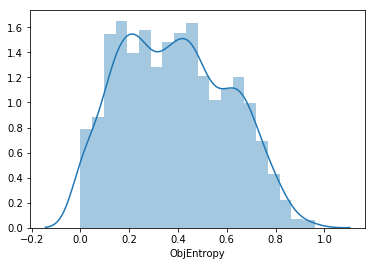

In [91]:
sns.distplot(df['ObjEntropy'])

/home/sagar/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


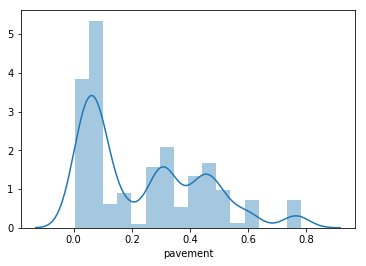

In [99]:
sns.distplot(df['pavement'])

In [100]:
df.corr()

,ObjEntropy,SceneEntropy,__background__,person,bicycle,car_coco,motorcycle,airplane,bus,train,...,road_marking,road,pavement,tree,sign_symbol,fence,car_enet,pedestrian,bicyclist,unlabeled
ObjEntropy,1.000000,0.446478,NaN,0.698649,0.206184,0.676393,0.154619,0.013671,0.452839,0.180522,...,0.574960,0.381563,-0.629548,-0.161854,-0.339846,0.345514,0.713404,0.421298,NaN,NaN
SceneEntropy,0.446478,1.000000,NaN,0.305960,0.103599,0.274100,0.039281,0.011281,0.168629,0.041450,...,0.396709,0.456651,-0.668430,0.131476,-0.167878,0.401218,0.333809,0.232568,NaN,NaN
__background__,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person,0.698649,0.305960,NaN,1.000000,0.107774,0.212113,0.040490,0.011978,0.145196,0.080644,...,0.499447,0.245398,-0.577291,-0.181306,-0.339690,0.272871,0.714982,0.363527,NaN,NaN
bicycle,0.206184,0.103599,NaN,0.107774,1.000000,0.145853,0.027657,-0.003576,0.042184,-0.000787,...,0.061169,0.088173,-0.117256,-0.009595,-0.088160,0.083266,0.146001,0.144507,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fence,0.345514,0.401218,NaN,0.272871,0.083266,0.277172,0.138071,-0.013940,0.231359,0.050950,...,0.014308,-0.055675,-0.419450,0.034922,-0.364443,1.000000,0.381009,0.140885,NaN,NaN
car_enet,0.713404,0.333809,NaN,0.714982,0.146001,0.440371,0.081796,-0.010488,0.318152,0.162098,...,0.469112,0.192064,-0.632389,-0.189313,-0.412918,0.381009,1.000000,0.461022,NaN,NaN
pedestrian,0.421298,0.232568,NaN,0.363527,0.144507,0.217612,0.064920,0.004384,0.170483,0.033945,...,0.272740,0.121894,-0.235658,0.085873,-0.175931,0.140885,0.461022,1.000000,NaN,NaN
bicyclist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
